# Improvements to the Embedding Training

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import inspect
import importlib

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D

from itertools import chain
from random import shuffle, sample

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations
import itertools
import plotly.express as px

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from sklearn.cluster import DBSCAN
from sklearn import metrics

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from prepare_utils import *
from performance_utils import *
from toy_utils import *
from models import *
from trainers import *
%matplotlib inline


# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import wandb
import faiss
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
torch_seed = 0

In [61]:
importlib.reload(sys.modules['toy_utils'])
from toy_utils import *

In [43]:
importlib.reload(sys.modules['models'])
from models import *

## Data Preparation

### Construct Truth with Primary Vertex

In [441]:
def select_hits(hits, truth, particles, pt_min=0, endcaps=False, noise=False):
    # Barrel volume and layer ids
    if endcaps:
        vlids = [(7, 2), (7, 4), (7, 6), (7, 8), (7, 10), (7, 12), (7, 14), (8, 2), (8, 4), (8, 6), (8, 8), (9, 2), (9, 4), (9, 6), (9, 8), (9, 10), (9, 12), (9, 14), (12, 2), (12, 4), (12, 6), (12, 8), (12, 10), (12, 12), (13, 2), (13, 4), (13, 6), (13, 8), (14, 2), (14, 4), (14, 6), (14, 8), (14, 10), (14, 12), (16, 2), (16, 4), (16, 6), (16, 8), (16, 10), (16, 12), (17, 2), (17, 4), (18, 2), (18, 4), (18, 6), (18, 8), (18, 10), (18, 12)]
    else:
        vlids = [(8,2), (8,4), (8,6), (8,8), (13,2), (13,4), (13,6), (13,8), (17,2), (17,4)]
    n_det_layers = len(vlids)
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    if noise is False:
        # Calculate particle transverse momentum
        pt = np.sqrt(particles.px**2 + particles.py**2)
        particles = particles.assign(pt=pt)
        # Applies pt cut, removes noise hits
        particles = particles[pt > pt_min]
        truth = (truth[['hit_id', 'particle_id']]
                 .merge(particles[['particle_id', 'pt', 'vx', 'vy', 'vz']], on='particle_id'))
    else:
        # Calculate particle transverse momentum
        pt = np.sqrt(truth.tpx**2 + truth.tpy**2)
        # Applies pt cut
        truth = truth[pt > pt_min]
        truth.loc[truth['particle_id'] == 0,'particle_id'] = float('NaN')
    # Calculate derived hits variables
    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)
    # Select the data columns we need
    hits = (hits[['hit_id', 'x', 'y', 'z', 'layer']]
            .assign(r=r, phi=phi)
            .merge(truth[['hit_id', 'particle_id', 'pt', 'vx', 'vy', 'vz']], on='hit_id'))
    # (DON'T) Remove duplicate hits
#     hits = hits.loc[
#         hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
#     ]
    return hits

In [339]:
input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all"
all_files = os.listdir(input_dir)
all_events = sorted(np.unique([os.path.join(input_dir, event[:14]) for event in all_files]))

In [442]:
%%time
hits, particles, truth = trackml.dataset.load_event(
        all_events[0], parts=['hits', 'particles', 'truth'])
hits = select_hits(hits, truth, particles, pt_min=0, endcaps=True, noise=False)

hits = hits.assign(R=np.sqrt((hits.x - hits.vx)**2 + (hits.y - hits.vy)**2 + (hits.z - hits.vz)**2))
hits = hits.sort_values('R').reset_index(drop=True).reset_index(drop=False)
layers = hits.layer.to_numpy()
hit_list = hits.groupby(['particle_id', 'layer'], sort=False)['index'].agg(lambda x: list(x)).groupby(level=0).agg(lambda x: list(x))

e = []
for row in hit_list.values:
    for i, j in zip(row[0:-1], row[1:]):
        e.extend(list(itertools.product(i, j)))

true_edges = np.array(e).T
print("Edges built for", all_events[0], "with size", true_edges.shape)


Exception: No file matches '/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/0_pt_cut_endcaps/all_events/1002-hits.csv*'

In [404]:
hits[(hits.pt < 0.2) & (hits.vx > 0.1) ][::100]

,index,hit_id,x,y,z,layer,r,phi,particle_id,pt,vx,vy,vz,R
6,6,39492,115.622002,-1.804990,383.661987,9,115.636086,-0.015610,707073800168022018,0.154458,115.622002,-1.804870,383.660004,0.001987
632,632,24870,30.167601,13.420400,163.932999,7,33.018044,0.418572,225182180408569858,0.191786,18.940399,-1.504040,174.276001,21.348692
5168,5168,19201,-31.920500,-5.461630,-63.358799,7,32.384373,-2.972133,153149600243384320,0.117173,8.882250,-16.755501,-10.064100,68.064240
9807,9807,44340,74.039597,-156.229996,205.143997,10,172.886307,-1.128234,90086698515431424,0.169954,7.955480,-73.460800,176.589005,109.696114
14816,14816,33208,-35.719601,61.892300,488.481995,8,71.460106,2.094226,225190632904200193,0.166334,16.734800,-63.431000,570.568970,158.731430
19517,19517,38527,-109.536003,40.385899,141.432999,9,116.743980,2.788357,153136406120632321,0.186906,12.327500,-14.458000,302.074005,208.959564
23436,23436,76670,117.126999,-237.371994,460.600006,24,264.696411,-1.112417,112590815334764545,0.181857,35.414902,-11.549200,570.568970,264.132507
27896,27896,67386,207.302994,-268.584991,-1795.500000,21,339.282227,-0.913467,292742978047320066,0.100771,251.561005,-408.933990,-1504.500000,326.094482
31579,31579,15710,57.307301,41.613400,-602.500000,6,70.822327,0.628058,27037334524395520,0.184054,8.475260,13.848700,-221.126999,385.487762
34917,34917,74888,18.468599,261.170013,-51.799999,24,261.822205,1.500199,220706274730323970,0.156210,16.203501,-27.681601,296.881989,452.790802


In [405]:
pid = 112594182589124609
sample_e = true_edges[:, hits.iloc[true_edges[0]].particle_id == pid]
sample = hits[hits.particle_id == pid]

In [406]:
sample_e

array([[   313,  15499,  15499,  29023,  29310,  38926,  64943],
       [ 15499,  29023,  29310,  38926,  38926,  64943, 103300]])

In [407]:
sample

,index,hit_id,x,y,z,layer,r,phi,particle_id,pt,vx,vy,vz,R
313,313,55863,18.987400,-69.523201,957.500000,14,72.069389,-1.304189,112594182589124609,0.157509,19.479601,-66.294403,962.5,5.972219
15499,15499,52961,19.627600,-158.619995,822.000000,13,159.829742,-1.447682,112594182589124609,0.157509,19.479601,-66.294403,962.5,168.119858
29023,29023,77560,53.819500,-251.917999,669.400024,24,257.602844,-1.360321,112594182589124609,0.157509,19.479601,-66.294403,962.5,348.630096
29310,29310,77286,55.476299,-254.753006,664.200012,24,260.723450,-1.356379,112594182589124609,0.157509,19.479601,-66.294403,962.5,354.676331
38926,38926,83722,125.630997,-334.072998,503.000000,25,356.914429,-1.211098,112594182589124609,0.157509,19.479601,-66.294403,962.5,542.322571
64943,64943,89048,320.518005,-383.178986,187.475006,26,499.557739,-0.874209,112594182589124609,0.157509,19.479601,-66.294403,962.5,889.777344
103300,103300,104923,625.539978,-441.858002,-2944.500000,34,765.858154,-0.614983,112594182589124609,0.157509,19.479601,-66.294403,962.5,3971.524414


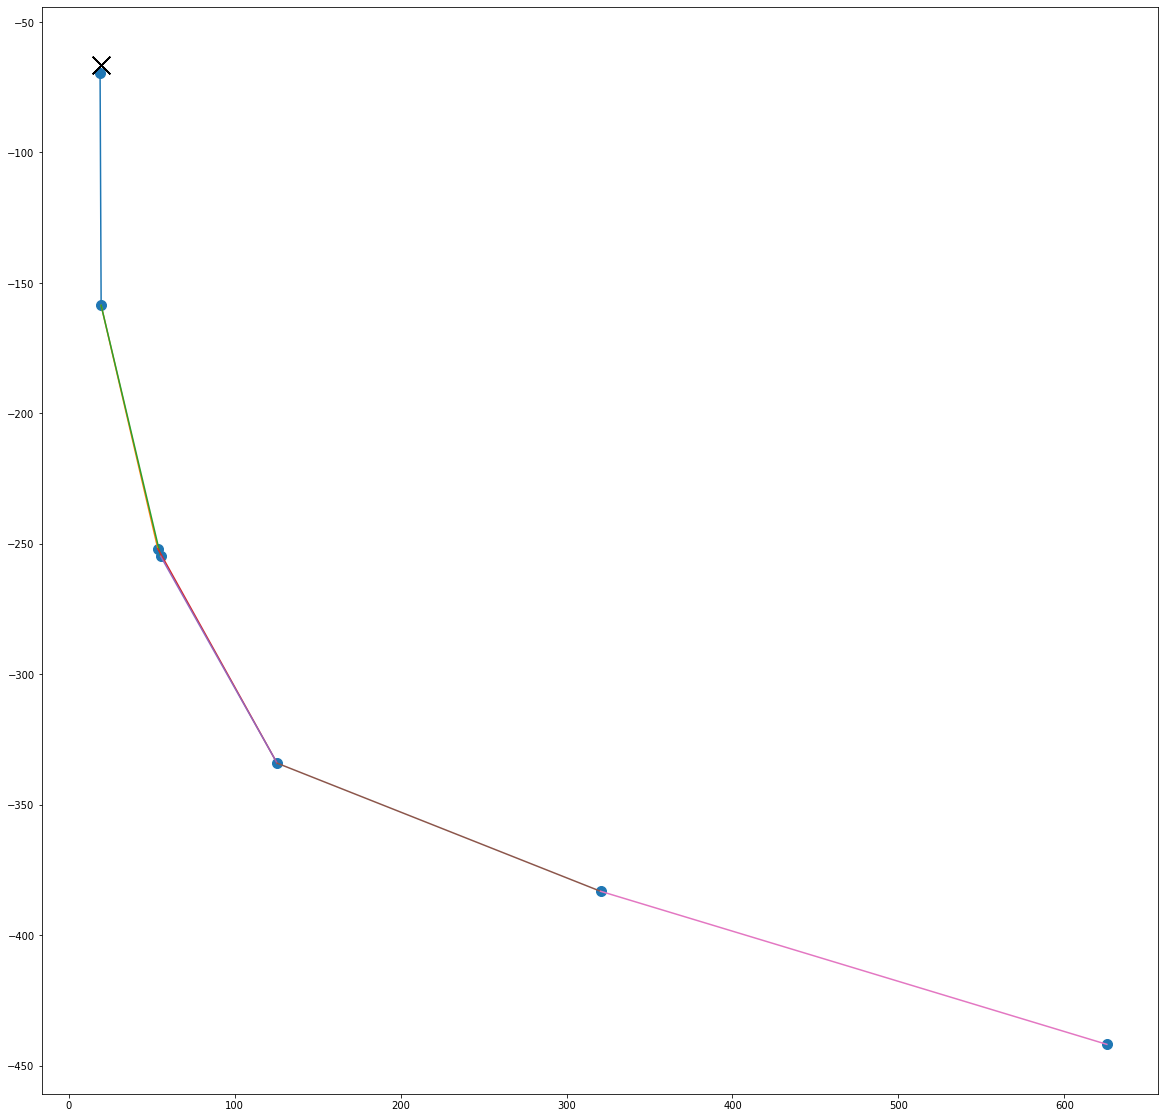

In [408]:
plt.figure(figsize=[20,20])
# plt.scatter(hits.x, hits.y, s=1)
plt.scatter(sample.x, sample.y, s=100)
plt.scatter(sample.vx, sample.vy, s=300, marker='x', c='k')
plt.plot([sample.x[sample_e[0]], sample.x[sample_e[1]]], [sample.y[sample_e[0]], sample.y[sample_e[1]]]);

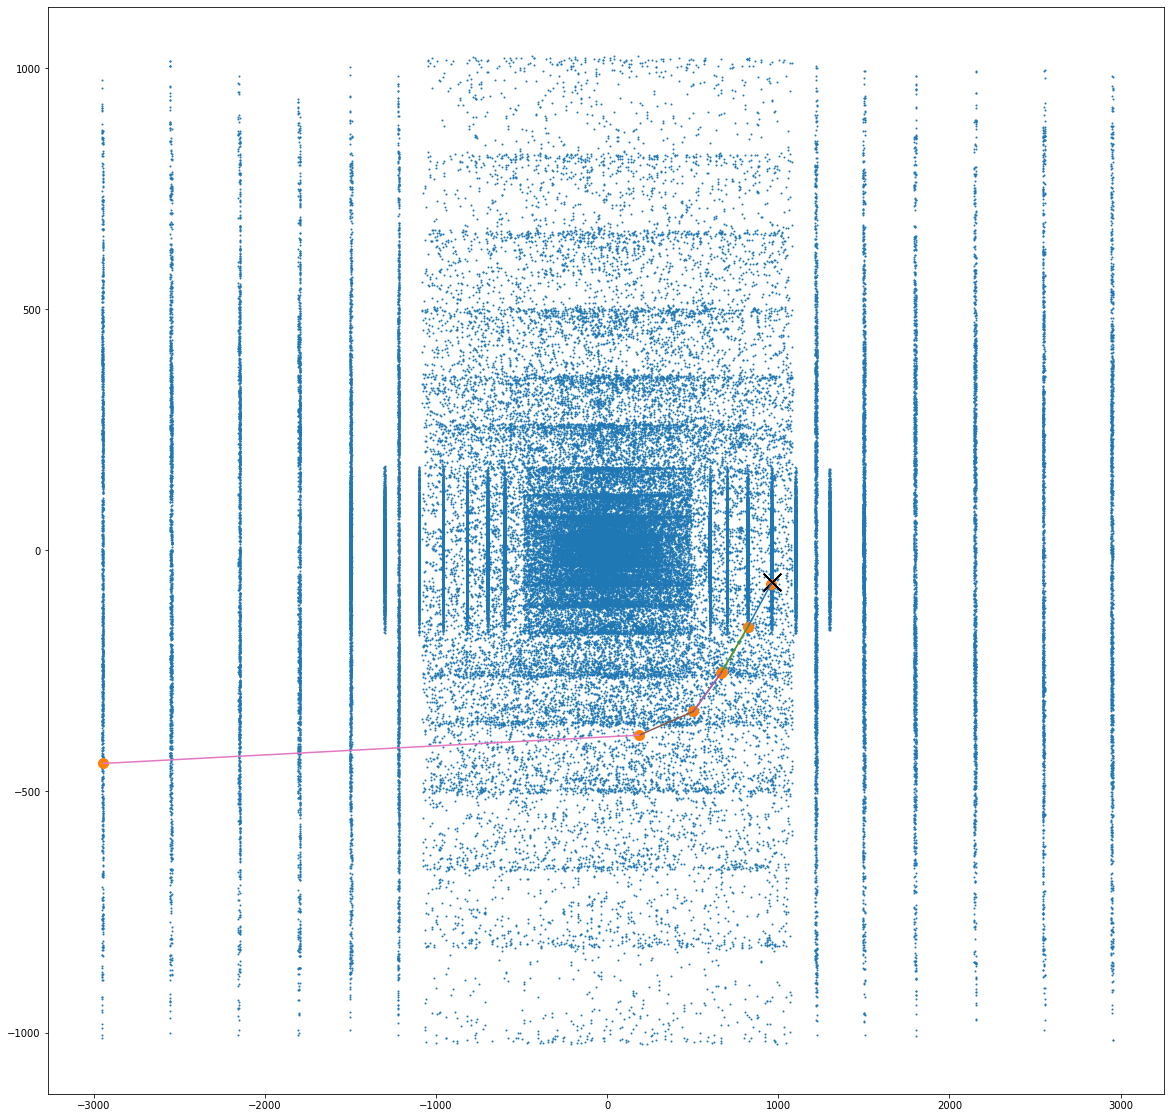

In [409]:
plt.figure(figsize=[20,20])
plt.scatter(hits.z, hits.y, s=1)
plt.scatter(sample.z, sample.y, s=100)
plt.scatter(sample.vz, sample.vy, s=300, marker='x', c='k')
plt.plot([sample.z[sample_e[0]], sample.z[sample_e[1]]], [sample.y[sample_e[0]], sample.y[sample_e[1]]]);

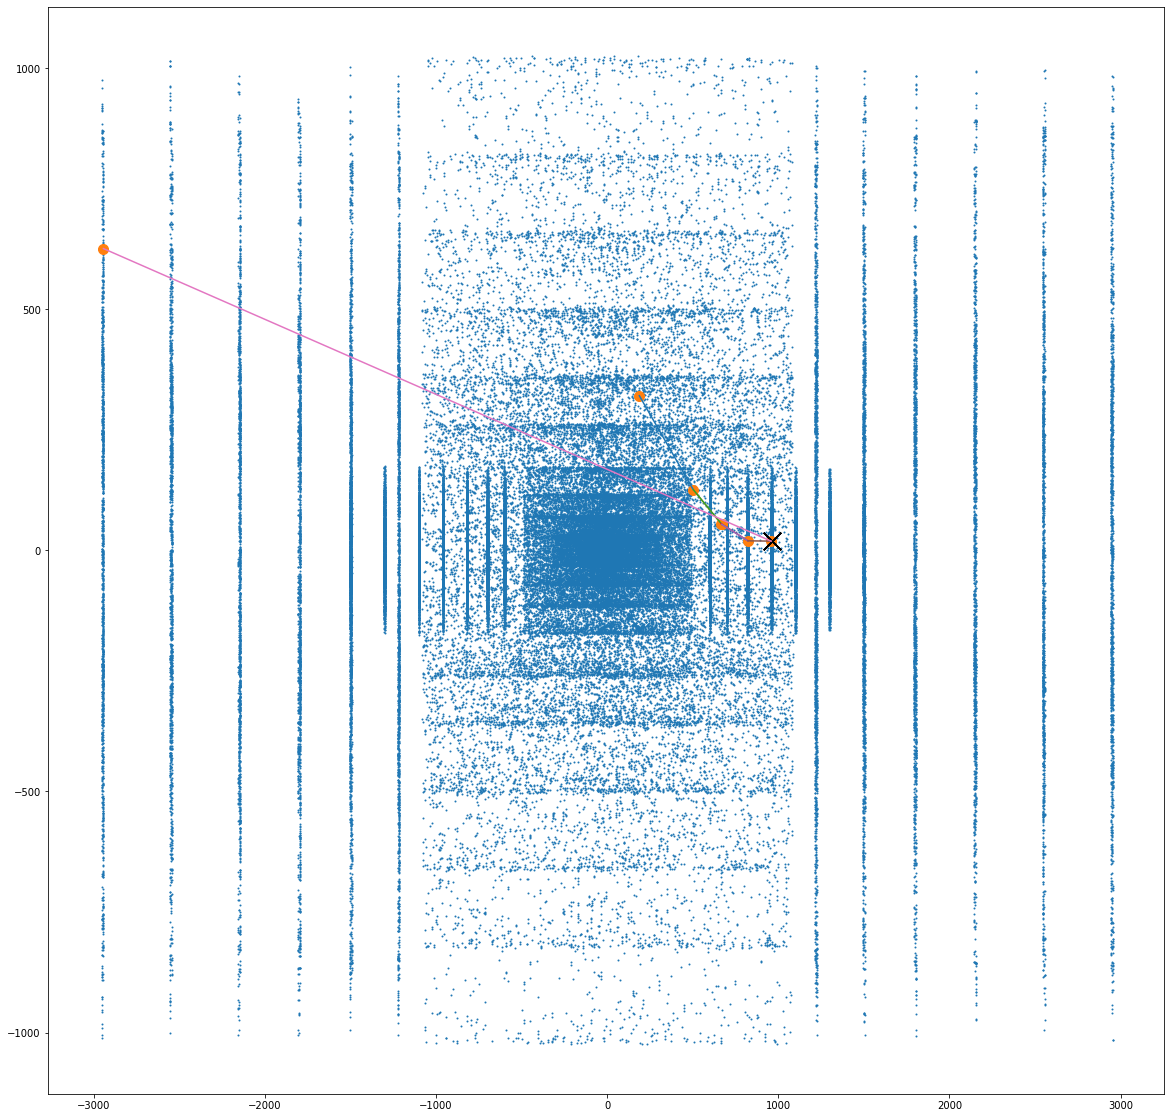

In [399]:
plt.figure(figsize=[20,20])
plt.scatter(hits.z, hits.y, s=1)
plt.scatter(sample.z, sample.x, s=100)
plt.scatter(sample.vz, sample.vx, s=300, marker='x', c='k')
plt.plot([sample.z[sample_e[0]], sample.z[sample_e[1]]], [sample.x[sample_e[0]], sample.x[sample_e[1]]]);

### Prepare Filter Candidates

In [6]:
pt_cut = 0
train_number = 1000
test_number = 100

In [7]:
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/"
# basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut_endcaps")
basename = os.path.join(save_dir, "1000_train_events")

In [ ]:
%%time
for i, batch in enumerate(train_dataset):
    if not os.path.exists(os.path.join(basename, batch.event_file[-4:])):
                
        data = batch.x.to(device)
        spatial = model(data)

        e_spatial = build_edges(spatial, 1.6, 1024, res)

        # Get the truth graphs
        e_bidir_layerless = torch.cat([batch.layerless_true_edges, 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T], axis=-1) 

        array_size = max(e_spatial.max().item(), e_bidir_layerless.max().item()) + 1

        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir_layerless.numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long()

        y = e_final.data > 0
        
        num_true = batch.y.sum()
        fake_indices = sample(list(np.where(batch.y == 0)), int(num_true*m_configs['ratio']))
        true_indices = np.where(batch.y == 1)
        combined_indices = np.concatenate([true_indices, fake_indices])

        batch.e_radius = e_spatial.cpu()
        batch.x = batch.x.cpu()
        batch.y = torch.from_numpy(y).float()
        batch.embedding = spatial.cpu().detach()

        with open(os.path.join(basename, batch.event_file[-4:]), 'wb') as pickle_file:
            torch.save(batch, pickle_file)
    
    print(i, "saved")



0 saved
1 saved
2 saved
3 saved
4 saved
5 saved
6 saved
7 saved
8 saved
9 saved
10 saved
11 saved
12 saved
13 saved
14 saved
15 saved
16 saved
17 saved
18 saved
19 saved
20 saved
21 saved
22 saved
23 saved
24 saved
25 saved
26 saved
27 saved
28 saved
29 saved
30 saved
31 saved
32 saved
33 saved
34 saved
35 saved
36 saved
37 saved
38 saved
39 saved
40 saved
41 saved
42 saved
43 saved
44 saved
45 saved
46 saved
47 saved
48 saved
49 saved
50 saved
51 saved
52 saved
53 saved
54 saved
55 saved
56 saved
57 saved
58 saved
59 saved
60 saved
61 saved
62 saved
63 saved
64 saved
65 saved
66 saved
67 saved
68 saved
69 saved
70 saved
71 saved
72 saved
73 saved
74 saved
75 saved
76 saved
77 saved
78 saved
79 saved
80 saved
81 saved
82 saved
83 saved
84 saved
85 saved
86 saved
87 saved
88 saved
89 saved
90 saved
91 saved
92 saved
93 saved
94 saved
95 saved
96 saved
97 saved
98 saved
99 saved
100 saved
101 saved
102 saved
103 saved
104 saved
105 saved
106 saved
107 saved
108 saved
109 saved
110 saved


840 saved
841 saved
842 saved
843 saved
844 saved
845 saved
846 saved
847 saved
848 saved
849 saved
850 saved
851 saved
852 saved
853 saved
854 saved
855 saved
856 saved
857 saved
858 saved
859 saved
860 saved
861 saved
862 saved
863 saved
864 saved
865 saved
866 saved
867 saved
868 saved
869 saved
870 saved
871 saved
872 saved
873 saved
874 saved
875 saved
876 saved
877 saved
878 saved
879 saved
880 saved
881 saved
882 saved
883 saved
884 saved
885 saved
886 saved
887 saved
888 saved
889 saved
890 saved
891 saved
892 saved
893 saved
894 saved
895 saved
896 saved
897 saved
898 saved
899 saved
900 saved
901 saved
902 saved
903 saved
904 saved
905 saved
906 saved
907 saved
908 saved
909 saved
910 saved
911 saved
912 saved
913 saved
914 saved
915 saved
916 saved
917 saved
918 saved
919 saved
920 saved
921 saved
922 saved
923 saved
924 saved
925 saved
926 saved
927 saved
928 saved
929 saved
930 saved


In [17]:
not os.path.exists(os.path.join(basename, train_dataset[400].event_file[-4:]))

True

In [62]:
test_dataset[0].event_file

'/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009650'

In [64]:
batch.event_file[0][-4:]

'9737'

In [52]:
test_dataset[1].hid

tensor([ 24542,  20489,  33676,  ..., 118872, 117860, 109986],
       dtype=torch.int32)

### Load & Save Raw Data

Load events:

In [2]:
pt_cut = 0
train_number = 1000
test_number = 100

In [3]:
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/truth_processed"
# basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut_endcaps")
basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut")
load_path = os.path.join(basename, "all_events")
all_events = os.listdir(load_path)
all_events = sorted([os.path.join(load_path, event) for event in all_events])

In [13]:
%%time
train_dataset = [torch.load(event) for event in all_events[:train_number]]
test_dataset = [torch.load(event) for event in all_events[-test_number:]]

CPU times: user 2.93 s, sys: 6.43 s, total: 9.36 s
Wall time: 1min 1s


In [14]:
with open(os.path.join(basename, str(train_number) + "_events_train"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(train_dataset, pickle_file)
with open(os.path.join(basename, str(test_number) + "_events_test"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(test_dataset, pickle_file)

### Load Scrubbed Events

In [4]:
pt_cut = 0
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/truth_processed"
train_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(train_number) + "_events_train")
test_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(test_number) + "_events_test")

In [5]:
%%time 
train_dataset = torch.load(train_path)
test_dataset = torch.load(test_path)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

CPU times: user 126 ms, sys: 4.14 s, total: 4.26 s
Wall time: 5.39 s


# Baseline Architectures

We begin by exploring manually tuned stages of the pipeline. These will form the baselines that we will aim to out-perform with an end-to-end architecture. 

## No Learning

Let's first look at what the ROC curve is of simply taking the nearest neighbours in (r,phi,z)

In [74]:
# model.eval()

pur, eff = [], []
r_min, r_max, r_step = 0.1, 1.8, 0.1


for r in np.arange(r_min, r_max, r_step):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    for batch in test_loader:
            data = batch.to(device)
#             emb_feats = model(data)

            e = radius_graph(data.x, r=r, batch=batch.batch, loop=False, max_num_neighbors=10000)

#             reference = emb_feats.index_select(0, e[1])
#             neighbors = emb_feats.index_select(0, e[0])

#             d = torch.sum((reference - neighbors)**2, dim=-1)

            y = batch.pid[e[0]] == batch.pid[e[1]]
#             hinge = y.float()
#             hinge[batch.pid[e[0]] != batch.pid[e[1]]] = -1 

#             loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs['margin'])
# #             print("Loss:", loss.item())
#             total_loss += loss.item()

            batch_cpu = batch.pid.cpu()
            pids, counts = np.unique(batch_cpu, return_counts=True)
            true = (counts * (counts -1)).sum()

            true_positive = (y.float()).sum().item()
            positive = len(e[0])

            total_positive += max(positive, 1)
            total_true += true
            correct += true_positive


    #         print("True positive:", true_positive, "Positive", positive, "True", true)

    pur.append(correct / total_positive)
    eff.append(correct / total_true)
    # print("Accuracy:", acc, "Efficiency:", eff)
pur, eff = np.array(pur), np.array(eff)

In [75]:
pur, eff

(array([0.02458922, 0.01358847, 0.00849905, 0.0059513 , 0.00458054,
        0.00374606, 0.00317166, 0.00277102, 0.00243801, 0.00219245,
        0.00198045, 0.00180599, 0.0016694 , 0.00156164, 0.00147822,
        0.0014156 , 0.00136943]),
 array([0.09129108, 0.26847558, 0.40926768, 0.51829957, 0.61384285,
        0.6981829 , 0.77088944, 0.83875708, 0.887582  , 0.93264084,
        0.96161841, 0.97701798, 0.98534917, 0.98853413, 0.98916554,
        0.98916554, 0.98916554]))

Text(0.5, 1.0, 'No Learning')

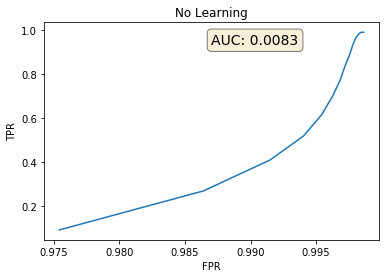

In [77]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-pur, eff)
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-pur, eff)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("No Learning")

## 1. Balanced Random Pairs

### Training

In [86]:
def train_connected_emb(model, train_loader, optimizer, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(data.x)
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        
        
        # Get random edge list
        n_random = int(m_configs['randomisation']*e_bidir.shape[1])
        e_spatial = torch.randint(e_bidir.min(), e_bidir.max(), (2, n_random)).to(device)
                
        array_size = e_bidir.max().item() + 1  
        
        tic = tt()
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
    
        e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,m_configs['weight']).view(-1, 2).transpose(0,1)], axis=-1) 
        y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*m_configs['weight'])])
        
        
#         print(y_cluster.sum(), len(y_cluster))
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        loss_vec.append(loss.item())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr.append(optimizer.param_groups[0]['lr'])
        
#         scheduler.step()
        
        if i % 200 == 0:
            print("i:", i, "LR:", optimizer.param_groups[0]['lr'], "LOSS:", loss.item())
            
    return total_loss

def evaluate_connected_emb(model, test_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        spatial = model(data.x)
        e_spatial = build_edges(spatial, m_configs['r_val'], 400, res)  
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
    
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss:", loss.item())
        total_loss += loss.item()
        
        #Cluster performance
        cluster_true = 2*len(batch.layerless_true_edges[0])
        
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])
        
        cluster_total_true_positive += cluster_true_positive
        cluster_total_positive += max(cluster_positive, 1)
        cluster_total_true += cluster_true
#         total_av_adjacent_nhood_size += len(e_adjacent[0]) / len(spatial)
        
#         print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive, "Av nhood size:", len(e_spatial[0])/len(spatial))
        if i % 10 == 0:
            print(i, "validated")

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss


In [87]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'weight': 1, 'randomisation': 1}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnections", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=0)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001, lr_decay=0, weight_decay=1e-3, initial_accumulator_value=0, eps=1e-10)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=True)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [88]:
loss_vec = []
lr = []
eff, pur = [], []
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss), "in time", tt() - tic)

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    eff.append(cluster_eff), pur.append(cluster_pur)
    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


i: 0 LR: 0.001 LOSS: 0.4996161162853241
i: 200 LR: 0.001 LOSS: 0.045931119471788406
i: 400 LR: 0.001 LOSS: 0.04607529193162918
i: 600 LR: 0.001 LOSS: 0.04596542939543724
i: 800 LR: 0.001 LOSS: 0.04141220077872276
Training loss: 50.3116 in time 61.79003548622131
0 validated


KeyboardInterrupt: 

Error in callback <function _init_jupyter.<locals>.cleanup at 0x2aabc0b3f680> (for post_run_cell):


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x2aab821d8d50>], None, Text(0.5, 1.0, 'Purity'))

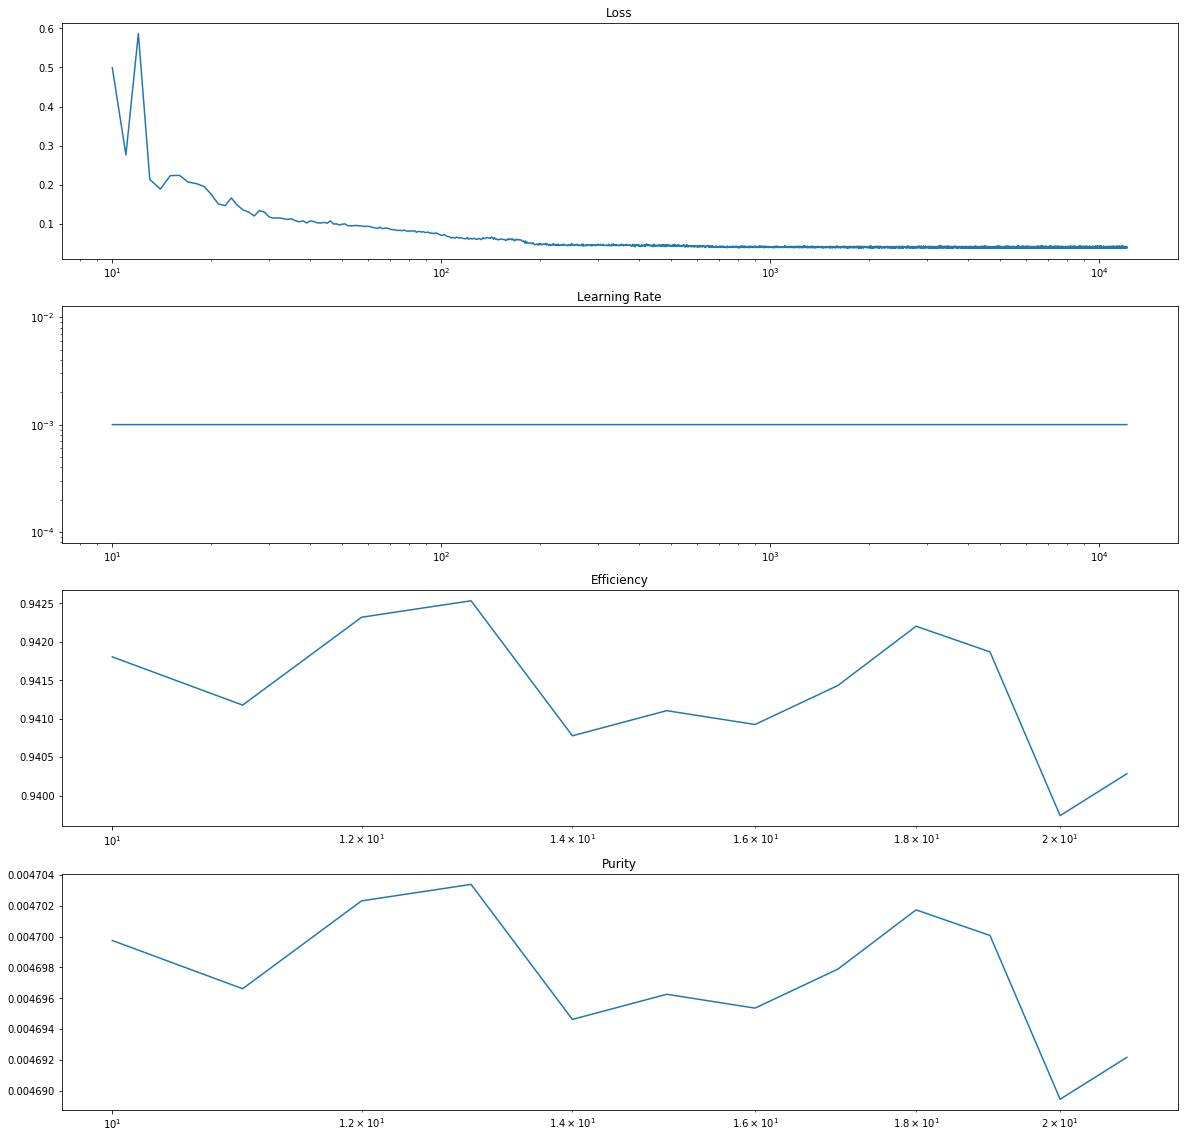

In [39]:
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
axs[0].plot(range(10,10+len(loss_vec)), loss_vec[:]), axs[0].set_xscale('log'), axs[0].set_title('Loss')
axs[1].plot(range(10,10+len(lr)), lr[:]), axs[1].set_xscale('log'), axs[1].set_yscale('log'), axs[1].set_title('Learning Rate')
axs[2].plot(range(10,10+len(eff)), eff[:]), axs[2].set_xscale('log'), axs[2].set_title('Efficiency')
axs[3].plot(range(10,10+len(pur)), pur[:]), axs[3].set_xscale('log'), axs[3].set_title('Purity')

In [91]:
model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_dataset):
            data = batch.to(device)
            spatial = model(data.x)
            e_spatial = build_edges(spatial, 0.45, 1024, res)  
            e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
            array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1

            l1 = e_spatial.cpu().numpy()
            l2 = e_bidir.cpu().numpy()
            e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
            e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
            e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

            e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
            y_cluster = e_final.data > 0

            hinge = torch.from_numpy(y_cluster).float().to(device)
            hinge[hinge == 0] = -1

            reference = spatial.index_select(0, e_spatial[1])
            neighbors = spatial.index_select(0, e_spatial[0])
            d = torch.sum((reference - neighbors)**2, dim=-1)

            loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
    #         print("Loss:", loss.item())
    #         total_loss += loss.item()

            #Cluster performance
            cluster_true = 2*len(batch.layerless_true_edges[0])

            cluster_true_positive = y_cluster.sum()
            cluster_positive = len(e_spatial[0])
            break
print("Eff:", cluster_true_positive/cluster_true, "Pur:", cluster_true_positive/cluster_positive)

Eff: 0.9598711071971819 Pur: 0.0033943397708702107


## 1a. Balanced Random Pairs with Warmup

In [ ]:
import pytorch_warmup as warmup

### Training

In [29]:
def train_connected_emb(model, train_loader, optimizer, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(data.x)
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        
        
        # Get random edge list
        n_random = int(m_configs['randomisation']*e_bidir.shape[1])
        e_spatial = torch.randint(e_bidir.min(), e_bidir.max(), (2, n_random)).to(device)
                
        array_size = e_bidir.max().item() + 1  
        
        tic = tt()
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
    
        e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,m_configs['weight']).view(-1, 2).transpose(0,1)], axis=-1) 
        y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*m_configs['weight'])])
        
        
#         print(y_cluster.sum(), len(y_cluster))
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        loss_vec.append(loss.item())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr.append(optimizer.param_groups[0]['lr'])
        
#         scheduler.step()
        
        if i % 200 == 0:
            print("i:", i, "LR:", optimizer.param_groups[0]['lr'], "LOSS:", loss.item())
            
    return total_loss

def evaluate_connected_emb(model, test_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        spatial = model(data.x)
        e_spatial = build_edges(spatial, m_configs['r_val'], 400, res)  
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
    
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss:", loss.item())
        total_loss += loss.item()
        
        #Cluster performance
        cluster_true = 2*len(batch.layerless_true_edges[0])
        
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])
        
        cluster_total_true_positive += cluster_true_positive
        cluster_total_positive += max(cluster_positive, 1)
        cluster_total_true += cluster_true
#         total_av_adjacent_nhood_size += len(e_adjacent[0]) / len(spatial)
        
#         print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive, "Av nhood size:", len(e_spatial[0])/len(spatial))
        if i % 10 == 0:
            print(i, "validated")

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss


In [32]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'weight': 1, 'randomisation': 1}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnections", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=0)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001, lr_decay=0, weight_decay=1e-3, initial_accumulator_value=0, eps=1e-10)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=True)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)
warmup_scheduler = warmup.UntunedExponentialWarmup(optimizer)


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
loss_vec = []
lr = []
eff, pur = [], []
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss), "in time", tt() - tic)

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    eff.append(cluster_eff), pur.append(cluster_pur)
    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


i: 0 LR: 0.001 LOSS: 0.49924758076667786
i: 200 LR: 0.001 LOSS: 0.048975128680467606
i: 400 LR: 0.001 LOSS: 0.04340739920735359
i: 600 LR: 0.001 LOSS: 0.04278760403394699
i: 800 LR: 0.001 LOSS: 0.041156526654958725
Training loss: 51.8172 in time 57.32181429862976
0 validated
10 validated
20 validated
30 validated
40 validated
50 validated
60 validated
70 validated
80 validated
90 validated
Epoch: 0, Eff: 0.9418, Pur: 0.0047, Loss: 89.7331, LR: 0.001 in time 252.77929377555847
i: 0 LR: 0.001 LOSS: 0.04177829995751381
i: 200 LR: 0.001 LOSS: 0.040721286088228226
i: 400 LR: 0.001 LOSS: 0.03978050500154495
i: 600 LR: 0.001 LOSS: 0.04053990915417671
i: 800 LR: 0.001 LOSS: 0.04248771816492081
Training loss: 40.9491 in time 56.88454008102417
0 validated
10 validated
20 validated
30 validated
40 validated
50 validated
60 validated
70 validated
80 validated
90 validated
Epoch: 1, Eff: 0.9412, Pur: 0.0047, Loss: 89.3355, LR: 0.001 in time 250.91233921051025
i: 0 LR: 0.001 LOSS: 0.0411592908203601

([<matplotlib.lines.Line2D at 0x2aab828e3050>],
 None,
 None,
 Text(0.5, 1.0, 'Learning Rate'))

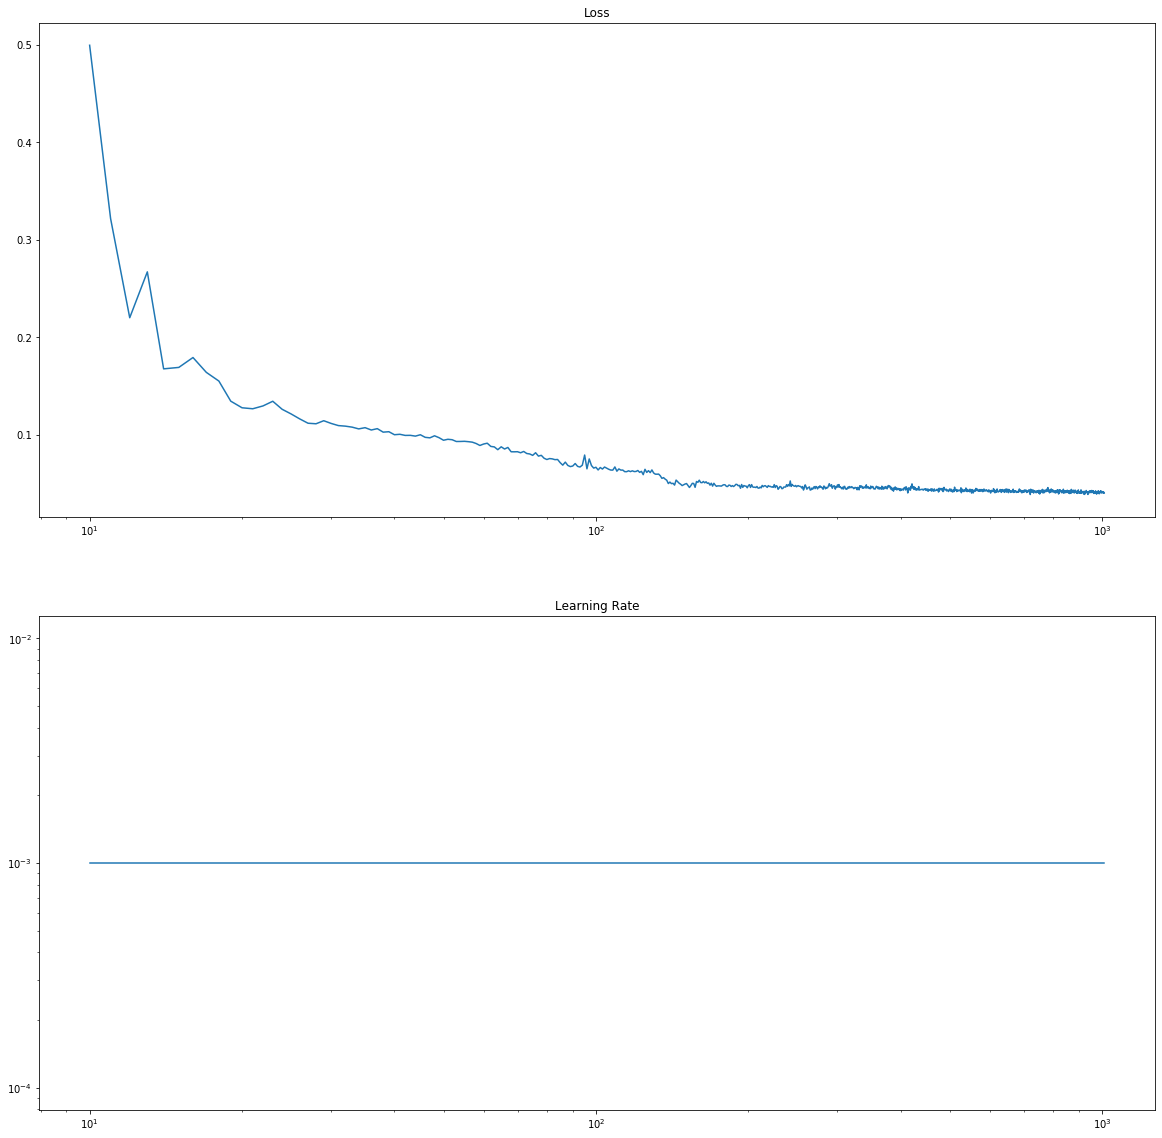

In [28]:
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
axs[0].plot(range(10,1010), loss_vec[:]), axs[0].set_xscale('log'), axs[0].set_title('Loss')
axs[1].plot(range(10,1010), lr[:]), axs[1].set_xscale('log'), axs[1].set_yscale('log'), axs[1].set_title('Learning Rate')
axs[2].plot(range(10,1010), eff_vec[:]), axs[2].set_xscale('log'), axs[2].set_title('Efficiency')
axs[3].plot(range(10,1010), pur_vec[:]), axs[3].set_xscale('log'), axs[3].set_title('Purity')

## 1b. Balanced Random Pairs with Cell Data

### Training

In [65]:
def train_connected_emb(model, train_loader, optimizer, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(torch.cat([data.cell_data, data.x], axis=1))
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        
        
        # Get random edge list
        n_random = int(m_configs['randomisation']*e_bidir.shape[1])
        e_spatial = torch.randint(e_bidir.min(), e_bidir.max(), (2, n_random)).to(device)
                
        array_size = e_bidir.max().item() + 1  
        
        tic = tt()
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
    
        e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,m_configs['weight']).view(-1, 2).transpose(0,1)], axis=-1) 
        y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*m_configs['weight'])])
        
        
#         print(y_cluster.sum(), len(y_cluster))
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        loss_vec.append(loss.item())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr.append(optimizer.param_groups[0]['lr'])
        
#         scheduler.step()
        
        if i % 200 == 0:
            print("i:", i, "LR:", optimizer.param_groups[0]['lr'], "LOSS:", loss.item())
            
    return total_loss

def evaluate_connected_emb(model, test_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        spatial = model(torch.cat([data.cell_data, data.x], axis=1))
        e_spatial = build_edges(spatial, m_configs['r_val'], 400, res)  
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
    
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss:", loss.item())
        total_loss += loss.item()
        
        #Cluster performance
        cluster_true = 2*len(batch.layerless_true_edges[0])
        
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])
        
        cluster_total_true_positive += cluster_true_positive
        cluster_total_positive += max(cluster_positive, 1)
        cluster_total_true += cluster_true
#         total_av_adjacent_nhood_size += len(e_adjacent[0]) / len(spatial)
        
#         print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive, "Av nhood size:", len(e_spatial[0])/len(spatial))
        if i % 10 == 0:
            print(i, "validated")

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss


In [68]:
m_configs = {"in_channels": 12, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'weight': 1, 'randomisation': 1}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnections", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=0)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001, lr_decay=0, weight_decay=1e-3, initial_accumulator_value=0, eps=1e-10)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=True)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [69]:
loss_vec = []
lr = []
eff, pur = [], []
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss), "in time", tt() - tic)

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    eff.append(cluster_eff), pur.append(cluster_pur)
    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


i: 0 LR: 0.001 LOSS: 0.49958324432373047
i: 200 LR: 0.001 LOSS: 0.04524335637688637
i: 400 LR: 0.001 LOSS: 0.04247312620282173
i: 600 LR: 0.001 LOSS: 0.03695832937955856
i: 800 LR: 0.001 LOSS: 0.03497780114412308
Training loss: 52.6227 in time 56.34012579917908
0 validated


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x2aabc7f3a350>], None, Text(0.5, 1.0, 'Purity'))

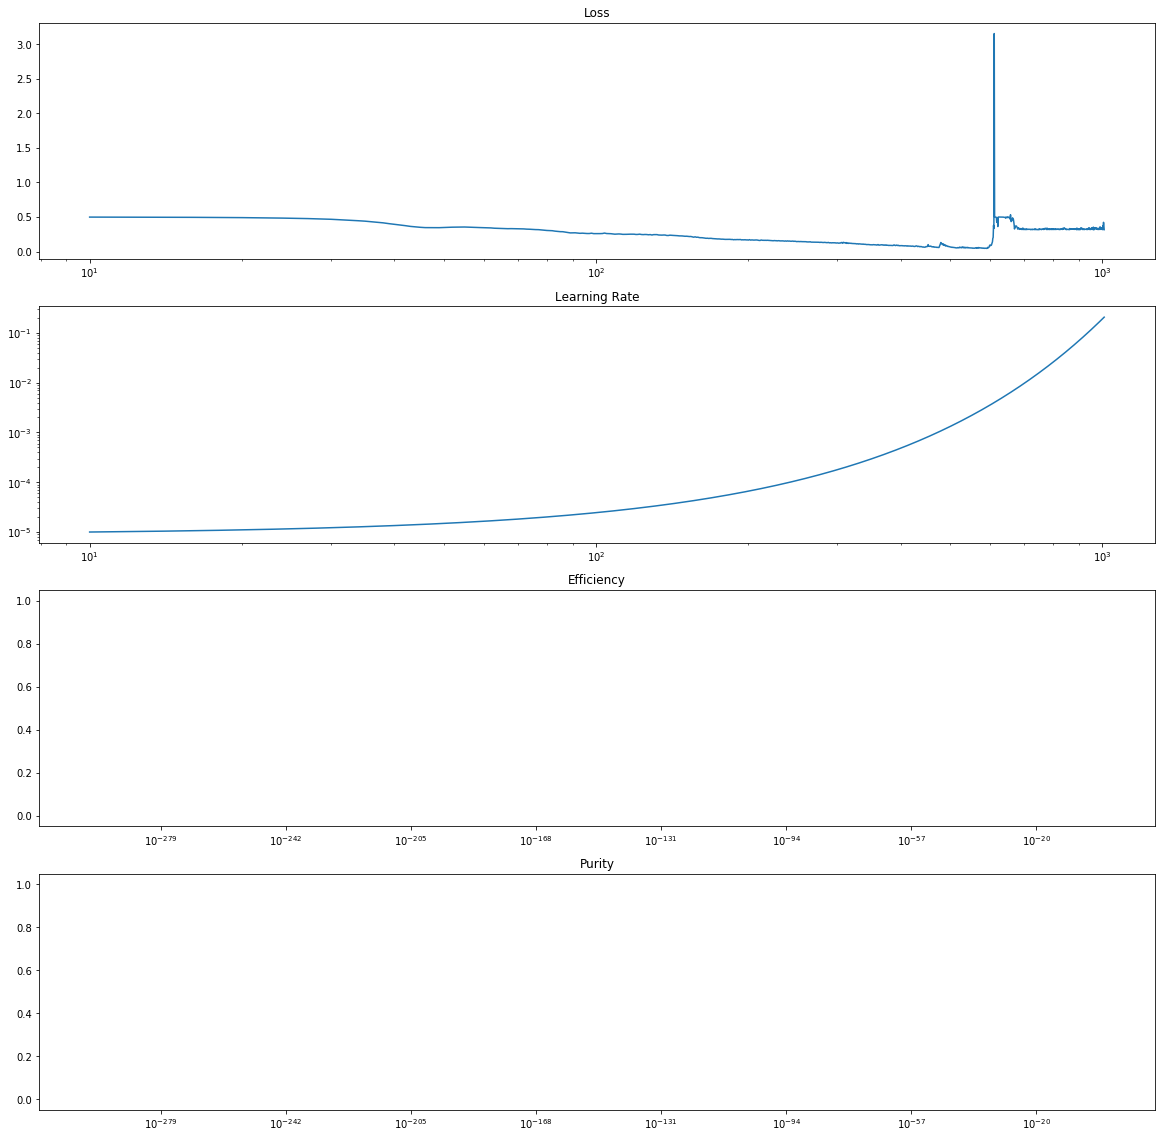

In [54]:
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
axs[0].plot(range(10,10+len(loss_vec)), loss_vec[:]), axs[0].set_xscale('log'), axs[0].set_title('Loss')
axs[1].plot(range(10,10+len(lr)), lr[:]), axs[1].set_xscale('log'), axs[1].set_yscale('log'), axs[1].set_title('Learning Rate')
axs[2].plot(range(10,10+len(eff)), eff[:]), axs[2].set_xscale('log'), axs[2].set_title('Efficiency')
axs[3].plot(range(10,10+len(pur)), pur[:]), axs[3].set_xscale('log'), axs[3].set_title('Purity')

In [50]:
other_configs['r_val'] = 0.8
model.eval()
with torch.no_grad():
    cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
print("Purity:", cluster_pur, "Efficiency:", cluster_eff)

0 validated
10 validated
20 validated
30 validated
40 validated
50 validated
60 validated
70 validated
80 validated
90 validated
Purity: 0.004880353739392917 Efficiency: 0.9669318491046536


In [85]:
model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_dataset):
            data = batch.to(device)
            spatial = model(torch.cat([data.cell_data, data.x], axis=1))
            e_spatial = build_edges(spatial, 0.4, 1024, res)  
            e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
            array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1

            l1 = e_spatial.cpu().numpy()
            l2 = e_bidir.cpu().numpy()
            e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
            e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
            e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

            e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
            y_cluster = e_final.data > 0

            hinge = torch.from_numpy(y_cluster).float().to(device)
            hinge[hinge == 0] = -1

            reference = spatial.index_select(0, e_spatial[1])
            neighbors = spatial.index_select(0, e_spatial[0])
            d = torch.sum((reference - neighbors)**2, dim=-1)

            loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
    #         print("Loss:", loss.item())
    #         total_loss += loss.item()

            #Cluster performance
            cluster_true = 2*len(batch.layerless_true_edges[0])

            cluster_true_positive = y_cluster.sum()
            cluster_positive = len(e_spatial[0])
            break
print("Eff:", cluster_true_positive/cluster_true, "Pur:", cluster_true_positive/cluster_positive)

Eff: 0.9622528220318629 Pur: 0.006287351501239541


## 2. Hard Negative Mining

### Training

In [46]:
def train_connected_emb(model, train_loader, optimizer, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(data.x)
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        
        # Get clustered edge list
        tic = tt()
        e_spatial = build_edges(spatial, m_configs['r_train'], 25, res) 
        
        knn_av.append(e_spatial.shape[1] / len(spatial))
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1  
        t1.append(tt() - tic)
        
        tic = tt()
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
#         print(y_cluster.sum(), len(y_cluster))
    
        eff_vec.append(y_cluster.sum() / e_bidir.shape[1])
        pur_vec.append(y_cluster.sum() / e_spatial.shape[1])
    
        e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,m_configs['weight']).view(-1, 2).transpose(0,1)], axis=-1) 
        y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*m_configs['weight'])])
        t2.append(tt() - tic)
        
        
#         print(y_cluster.sum(), len(y_cluster))
        tic = tt()
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        loss_vec.append(loss.item())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr.append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()
        
        print("i:", i, "LR:", optimizer.param_groups[0]['lr'], "KNN:", knn_av[-1], "LOSS:", loss.item())
            
    return total_loss

def evaluate_connected_emb(model, test_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        spatial = model(data.x)
        e_spatial = build_edges(spatial, m_configs['r_val'], 200, res)  
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
    
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss:", loss.item())
        total_loss += loss.item()
        
        #Cluster performance
        cluster_true = 2*len(batch.layerless_true_edges[0])
        
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])
        
        cluster_total_true_positive += cluster_true_positive
        cluster_total_positive += max(cluster_positive, 1)
        cluster_total_true += cluster_true
#         total_av_adjacent_nhood_size += len(e_adjacent[0]) / len(spatial)
        
#         print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive, "Av nhood size:", len(e_spatial[0])/len(spatial))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss


In [53]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'weight': 1}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnections", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=0)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001, lr_decay=0, weight_decay=1e-3, initial_accumulator_value=0, eps=1e-10)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=True)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [54]:
t1, t2, = [], []
knn_av = []
loss_vec = []
eff_vec = []
pur_vec = []
lr = []
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss), "in time", tt() - tic)

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))
    break

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


i: 0 LR: 0.001 KNN: 24.0 LOSS: 0.9220069050788879
i: 1 LR: 0.001 KNN: 24.0 LOSS: 0.9231750965118408
i: 2 LR: 0.001 KNN: 24.0 LOSS: 0.9189381003379822
i: 3 LR: 0.001 KNN: 24.0 LOSS: 0.9236063361167908
i: 4 LR: 0.001 KNN: 24.0 LOSS: 0.9232086539268494
i: 5 LR: 0.001 KNN: 24.0 LOSS: 0.9234567284584045
i: 6 LR: 0.001 KNN: 24.0 LOSS: 0.916347086429596
i: 7 LR: 0.001 KNN: 24.0 LOSS: 0.9225072860717773
i: 8 LR: 0.001 KNN: 24.0 LOSS: 0.919062077999115
i: 9 LR: 0.001 KNN: 24.0 LOSS: 0.922687828540802
i: 10 LR: 0.001 KNN: 24.0 LOSS: 0.9200664162635803
i: 11 LR: 0.001 KNN: 24.0 LOSS: 0.9203069806098938
i: 12 LR: 0.001 KNN: 24.0 LOSS: 0.9221336245536804
i: 13 LR: 0.001 KNN: 24.0 LOSS: 0.9228941798210144
i: 14 LR: 0.001 KNN: 24.0 LOSS: 0.921893835067749
i: 15 LR: 0.001 KNN: 24.0 LOSS: 0.9227305054664612
i: 16 LR: 0.001 KNN: 24.0 LOSS: 0.9223371744155884
i: 17 LR: 0.001 KNN: 24.0 LOSS: 0.9173190593719482
i: 18 LR: 0.001 KNN: 24.0 LOSS: 0.922126293182373
i: 19 LR: 0.001 KNN: 24.0 LOSS: 0.921567320823

i: 161 LR: 0.001 KNN: 24.0 LOSS: 0.9192538261413574
i: 162 LR: 0.001 KNN: 24.0 LOSS: 0.922666609287262
i: 163 LR: 0.001 KNN: 24.0 LOSS: 0.9174942970275879
i: 164 LR: 0.001 KNN: 24.0 LOSS: 0.9169279932975769
i: 165 LR: 0.001 KNN: 24.0 LOSS: 0.9175886511802673
i: 166 LR: 0.001 KNN: 24.0 LOSS: 0.9146688580513
i: 167 LR: 0.001 KNN: 24.0 LOSS: 0.9176449179649353
i: 168 LR: 0.001 KNN: 24.0 LOSS: 0.9174969792366028
i: 169 LR: 0.001 KNN: 24.0 LOSS: 0.9194308519363403
i: 170 LR: 0.001 KNN: 24.0 LOSS: 0.9190654158592224
i: 171 LR: 0.001 KNN: 24.0 LOSS: 0.9200925230979919
i: 172 LR: 0.001 KNN: 24.0 LOSS: 0.9207934737205505
i: 173 LR: 0.001 KNN: 24.0 LOSS: 0.9218282699584961
i: 174 LR: 0.001 KNN: 24.0 LOSS: 0.9217556715011597
i: 175 LR: 0.001 KNN: 24.0 LOSS: 0.9222292900085449
i: 176 LR: 0.001 KNN: 24.0 LOSS: 0.9224838018417358
i: 177 LR: 0.001 KNN: 24.0 LOSS: 0.9220587015151978
i: 178 LR: 0.001 KNN: 24.0 LOSS: 0.9227393269538879
i: 179 LR: 0.001 KNN: 24.0 LOSS: 0.9233070015907288
i: 180 LR: 0.001

i: 320 LR: 0.0001 KNN: 23.966372726889162 LOSS: 0.8752253651618958
i: 321 LR: 0.0001 KNN: 23.88809263618023 LOSS: 0.871249258518219
i: 322 LR: 0.0001 KNN: 23.714627182789986 LOSS: 0.8551656007766724
i: 323 LR: 0.0001 KNN: 23.844464002816405 LOSS: 0.8750377893447876
i: 324 LR: 0.0001 KNN: 23.284361860160637 LOSS: 0.8358584642410278
i: 325 LR: 0.0001 KNN: 22.93508091227406 LOSS: 0.8497386574745178
i: 326 LR: 0.0001 KNN: 23.590655969797073 LOSS: 0.8668654561042786
i: 327 LR: 0.0001 KNN: 23.387354131936174 LOSS: 0.8477242588996887
i: 328 LR: 0.0001 KNN: 21.886381927677405 LOSS: 0.8102986216545105
i: 329 LR: 0.0001 KNN: 22.993151210528335 LOSS: 0.851170539855957
i: 330 LR: 0.0001 KNN: 23.137241249529545 LOSS: 0.8297296166419983
i: 331 LR: 0.0001 KNN: 22.457382413087934 LOSS: 0.8358296155929565
i: 332 LR: 0.0001 KNN: 20.297840596780524 LOSS: 0.8352507948875427
i: 333 LR: 0.0001 KNN: 20.834232790516815 LOSS: 0.8375672698020935
i: 334 LR: 0.0001 KNN: 20.906139187070316 LOSS: 0.8342795372009277

i: 444 LR: 0.0001 KNN: 15.614491279377795 LOSS: 0.7887578010559082
i: 445 LR: 0.0001 KNN: 13.807285546415981 LOSS: 0.8454867601394653
i: 446 LR: 0.0001 KNN: 13.422022002090696 LOSS: 0.8417794704437256
i: 447 LR: 0.0001 KNN: 16.39365416144276 LOSS: 0.7780331969261169
i: 448 LR: 0.0001 KNN: 13.699533437013997 LOSS: 0.844569742679596
i: 449 LR: 0.0001 KNN: 13.482804725686606 LOSS: 0.8558450937271118
i: 450 LR: 0.0001 KNN: 15.189665041549059 LOSS: 0.8179492354393005
i: 451 LR: 0.0001 KNN: 16.062058206051734 LOSS: 0.802237331867218
i: 452 LR: 0.0001 KNN: 13.675271475664147 LOSS: 0.8581895232200623
i: 453 LR: 0.0001 KNN: 17.07597458029024 LOSS: 0.7417429685592651
i: 454 LR: 0.0001 KNN: 15.977801165487536 LOSS: 0.7607587575912476
i: 455 LR: 0.0001 KNN: 14.016418319387949 LOSS: 0.8821142315864563
i: 456 LR: 0.0001 KNN: 16.860262374083867 LOSS: 0.7990113496780396
i: 457 LR: 0.0001 KNN: 12.326427355346139 LOSS: 0.8775476813316345
i: 458 LR: 0.0001 KNN: 12.268846723840529 LOSS: 0.8981332182884216

i: 567 LR: 0.0001 KNN: 15.51067562363613 LOSS: 0.7287461757659912
i: 568 LR: 0.0001 KNN: 14.348871807587404 LOSS: 0.7656280994415283
i: 569 LR: 0.0001 KNN: 17.795605416887945 LOSS: 0.7392455339431763
i: 570 LR: 0.0001 KNN: 13.227195480433585 LOSS: 0.8378757834434509
i: 571 LR: 0.0001 KNN: 14.524853772569886 LOSS: 0.8010681867599487
i: 572 LR: 0.0001 KNN: 13.165748327674196 LOSS: 0.8584557771682739
i: 573 LR: 0.0001 KNN: 13.049332432647223 LOSS: 0.8765431046485901
i: 574 LR: 0.0001 KNN: 13.96308846205098 LOSS: 0.8138864636421204
i: 575 LR: 0.0001 KNN: 14.37449014446744 LOSS: 0.8240946531295776
i: 576 LR: 0.0001 KNN: 11.50456351336841 LOSS: 0.863476574420929
i: 577 LR: 0.0001 KNN: 11.117640100547094 LOSS: 0.8881499767303467
i: 578 LR: 0.0001 KNN: 15.599593800106895 LOSS: 0.7462652325630188
i: 579 LR: 0.0001 KNN: 17.247845603136422 LOSS: 0.7212773561477661
i: 580 LR: 0.0001 KNN: 16.120609226107412 LOSS: 0.7458567023277283
i: 581 LR: 0.0001 KNN: 13.313763119861635 LOSS: 0.8035366535186768


i: 693 LR: 1e-05 KNN: 15.733532481282614 LOSS: 0.7627905607223511
i: 694 LR: 1e-05 KNN: 11.762038682974715 LOSS: 0.8702900409698486
i: 695 LR: 1e-05 KNN: 11.705721413052226 LOSS: 0.8400612473487854
i: 696 LR: 1e-05 KNN: 13.863271543857335 LOSS: 0.793098509311676
i: 697 LR: 1e-05 KNN: 13.988300158457966 LOSS: 0.796166181564331
i: 698 LR: 1e-05 KNN: 15.473016905071521 LOSS: 0.755029022693634
i: 699 LR: 1e-05 KNN: 12.683113289971848 LOSS: 0.7937036752700806
i: 700 LR: 1e-05 KNN: 12.881060713777904 LOSS: 0.8118540644645691
i: 701 LR: 1e-05 KNN: 12.840332147093713 LOSS: 0.8318282961845398
i: 702 LR: 1e-05 KNN: 13.853218977309739 LOSS: 0.7870734930038452
i: 703 LR: 1e-05 KNN: 13.659457806321953 LOSS: 0.8195661306381226
i: 704 LR: 1e-05 KNN: 11.653903726463405 LOSS: 0.8887945413589478
i: 705 LR: 1e-05 KNN: 16.394937287807625 LOSS: 0.7304865121841431
i: 706 LR: 1e-05 KNN: 15.638336279892062 LOSS: 0.7870270013809204
i: 707 LR: 1e-05 KNN: 12.244823990864406 LOSS: 0.8804974555969238
i: 708 LR: 1e

i: 819 LR: 1e-05 KNN: 14.724167293754208 LOSS: 0.7769133448600769
i: 820 LR: 1e-05 KNN: 12.227251249658053 LOSS: 0.85614413022995
i: 821 LR: 1e-05 KNN: 13.996223419093191 LOSS: 0.82184237241745
i: 822 LR: 1e-05 KNN: 13.11849990780011 LOSS: 0.8405681848526001
i: 823 LR: 1e-05 KNN: 14.18735476783979 LOSS: 0.7992843389511108
i: 824 LR: 1e-05 KNN: 12.853696855437121 LOSS: 0.8352197408676147
i: 825 LR: 1e-05 KNN: 13.48235427022142 LOSS: 0.7939617037773132
i: 826 LR: 1e-05 KNN: 13.442706780710404 LOSS: 0.7712178826332092
i: 827 LR: 1e-05 KNN: 16.02430959637942 LOSS: 0.7540781497955322
i: 828 LR: 1e-05 KNN: 14.572249199297447 LOSS: 0.7693186402320862
i: 829 LR: 1e-05 KNN: 14.353132065991122 LOSS: 0.777320384979248
i: 830 LR: 1e-05 KNN: 14.71993587402086 LOSS: 0.7816202044487
i: 831 LR: 1e-05 KNN: 14.939730825233166 LOSS: 0.7769595384597778
i: 832 LR: 1e-05 KNN: 11.805294223780189 LOSS: 0.8693087697029114
i: 833 LR: 1e-05 KNN: 12.988241842343282 LOSS: 0.8220187425613403
i: 834 LR: 1e-05 KNN: 1

i: 936 LR: 1.0000000000000002e-06 KNN: 14.538917777055573 LOSS: 0.7736017107963562
i: 937 LR: 1.0000000000000002e-06 KNN: 14.239403857633958 LOSS: 0.8075658082962036
i: 938 LR: 1.0000000000000002e-06 KNN: 12.488361345559799 LOSS: 0.8426622152328491
i: 939 LR: 1.0000000000000002e-06 KNN: 15.268055529179406 LOSS: 0.7675091028213501
i: 940 LR: 1.0000000000000002e-06 KNN: 14.865408458465353 LOSS: 0.7600619196891785
i: 941 LR: 1.0000000000000002e-06 KNN: 12.769441816461685 LOSS: 0.8675029277801514
i: 942 LR: 1.0000000000000002e-06 KNN: 13.495465878251661 LOSS: 0.8186948299407959
i: 943 LR: 1.0000000000000002e-06 KNN: 13.527943979080796 LOSS: 0.8047105073928833
i: 944 LR: 1.0000000000000002e-06 KNN: 15.726943576548429 LOSS: 0.7678069472312927
i: 945 LR: 1.0000000000000002e-06 KNN: 14.831469363474122 LOSS: 0.769396185874939
i: 946 LR: 1.0000000000000002e-06 KNN: 13.424905258958846 LOSS: 0.796172022819519
i: 947 LR: 1.0000000000000002e-06 KNN: 13.166294969701065 LOSS: 0.8065418601036072
i: 948

([<matplotlib.lines.Line2D at 0x2aaca9d40a10>],
 None,
 None,
 Text(0.5, 1.0, 'Learning Rate'))

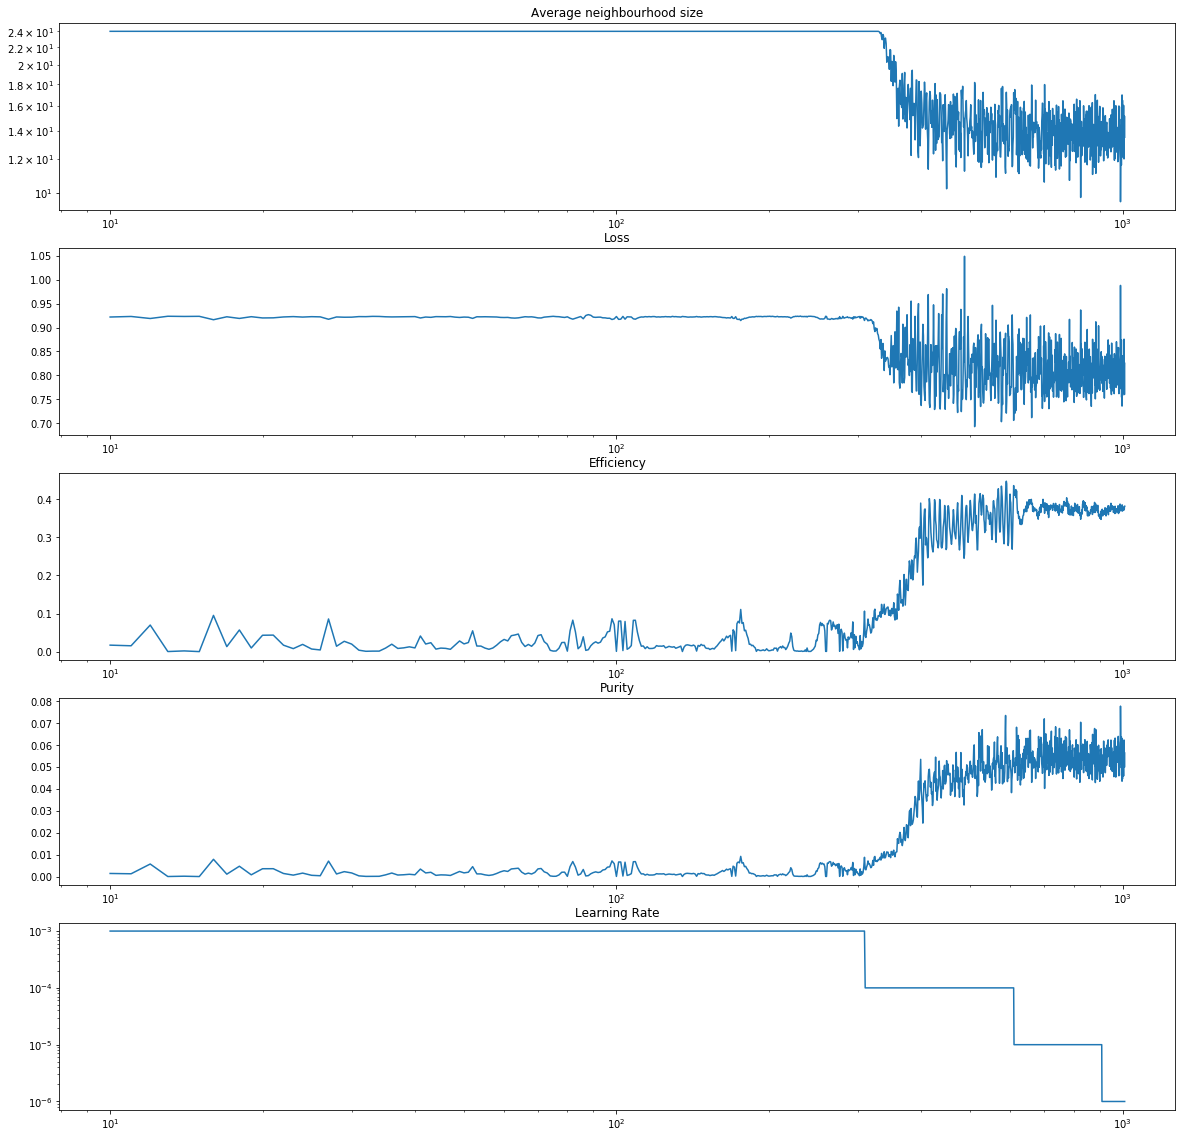

In [55]:
fig, axs = plt.subplots(5, 1, figsize=(20, 20))
axs[0].plot(range(10,1010), knn_av[:]), axs[0].set_xscale('log'), axs[0].set_yscale('log'), axs[0].set_title('Average neighbourhood size')
axs[1].plot(range(10,1010), loss_vec[:]), axs[1].set_xscale('log'), axs[1].set_title('Loss')
axs[2].plot(range(10,1010), eff_vec[:]), axs[2].set_xscale('log'), axs[2].set_title('Efficiency')
axs[3].plot(range(10,1010), pur_vec[:]), axs[3].set_xscale('log'), axs[3].set_title('Purity')
axs[4].plot(range(10,1010), lr[:]), axs[4].set_xscale('log'), axs[4].set_yscale('log'), axs[4].set_title('Learning Rate')

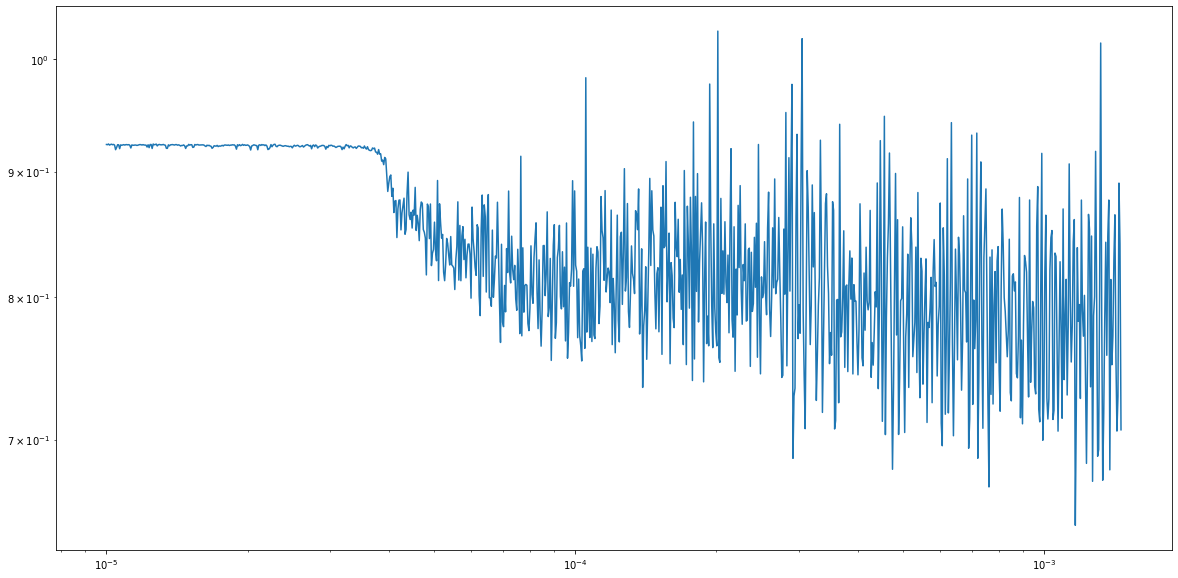

In [50]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(lr, loss_vec)
ax.set_xscale('log')
ax.set_yscale('log')

In [93]:
torch.cuda.max_memory_allocated() / 1024**3

3.0723562240600586

### ROC Results

Want to get efficiency also, which is number of particles in batch with same PID, under the number of particles in neighbourhood with same PID. Use neighbours and reference with batch.pid

In [6]:
checkpoint = torch.load('/global/cscratch1/sd/danieltm/ExaTrkX/model_comparisons/Embedding/kind-frog-88.tar')
checkpoint['config']

{'in_channels': 3,
 'emb_hidden': 512,
 'nb_layer': 6,
 'emb_dim': 8,
 'r_train': 1,
 'r_val': 1,
 'margin': 1,
 'reduction': 'mean',
 'lr': 0.001,
 'weight_decay': 0.001,
 'factor': 0.3,
 'patience': 5,
 'epochs': 30,
 'weight': 8,
 'pt_min': 0,
 'train_number': 4000,
 'test_number': 400,
 'endcaps': False,
 'layerwise': False,
 'layerless': True,
 'noise': False,
 'adjacent': True}

In [7]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'weight': 8, 
                 'layerwise': False, 'layerless': True, 'endcaps': False}
model = Embedding(**m_configs).to(device)

m_configs.update(other_configs)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Connected Truth Graph

In [16]:
def compare_embedding_models(test_loader, model, r_min, r_max, r_step, m_configs):
    
    model.eval()
    
    total_true_positive_layerless, total_positive_layerless, total_true_layerless = np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float)
    total_true_positive_layerwise, total_positive_layerwise, total_true_layerwise = np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float)

    for batch in test_loader:

        data = batch.to(device)
        spatial = model(data.x)

        for i, r in enumerate(np.arange(r_min, r_max, r_step)):    

            e_spatial = build_edges(spatial, r, 1024, res)
            
            # Get the truth graphs
            e_bidir_layerless = torch.cat([batch.layerless_true_edges.to(device), 
                                       torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
            e_bidir_layerwise = torch.cat([batch.layerwise_true_edges.to(device), 
                                   torch.stack([batch.layerwise_true_edges[1], batch.layerwise_true_edges[0]], axis=1).T.to(device)], axis=-1) 
            
            array_size = max(e_spatial.max().item(), e_bidir_layerless.max().item()) + 1
            
            l1 = e_spatial.cpu().numpy()
            l2 = e_bidir_layerless.cpu().numpy()
            e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
            e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
            e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

            e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
            e_adjacent = e_spatial[:, ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1) | 
                            (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1))]
            
            y_layerless = e_final.data > 0

            y_layerwise = (batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1) | 
                                                                                (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1))
            
            true_layerless = e_bidir_layerless.shape[1]
            true_positive_layerless = y_layerless.sum()
            positive_layerless = e_spatial.shape[1]
            
            true_layerwise = e_bidir_layerwise.shape[1]
            true_positive_layerwise = y_layerwise.sum()
            positive_layerwise = e_adjacent.shape[1]

#             print("True:", true, "Positive:", positive, "True Positive:", true_positive)
            
            total_positive_layerless[i] += positive_layerless
            total_true_layerless[i] += true_layerless
            total_true_positive_layerless[i] += true_positive_layerless
            
            total_positive_layerwise[i] += positive_layerwise
            total_true_layerwise[i] += true_layerwise
            total_true_positive_layerwise[i] += true_positive_layerwise
            
    pur_layerless, eff_layerless = total_true_positive_layerless / total_positive_layerless, total_true_positive_layerless / total_true_layerless
    pur_layerwise, eff_layerwise = total_true_positive_layerwise / total_positive_layerwise, total_true_positive_layerwise / total_true_layerwise
#     f1 = 2*pur*eff/(pur+eff)
    return pur_layerless, eff_layerless, pur_layerwise, eff_layerwise

In [17]:
%%time

r_min, r_max, r_step = 1, 1.1, 0.1
with torch.no_grad():
    pur_layerless, eff_layerless, pur_layerwise, eff_layerwise = compare_embedding_models(test_loader, model, r_min, r_max, r_step, m_configs)

CPU times: user 1min 28s, sys: 49.9 s, total: 2min 18s
Wall time: 1min 47s


In [18]:
pur_layerless, eff_layerless

(array([0.07141684, 0.03745536]), array([0.78143157, 0.82265319]))

In [19]:
pur_layerwise, eff_layerwise

(array([0.13348937, 0.06914008]), array([0.70740683, 0.75289242]))

#### PID Truth

In [53]:
def compare_embedding_models(test_loader, model, r_min, r_max, r_step, m_configs):
    
    model.eval()
    
    total_true_positive_layerless_connected, total_true_positive_layerless_pid, total_positive_layerless, total_true_layerless = np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float)
    
    for batch in test_loader:

        data = batch.to(device)
        spatial = model(data.x)

        for i, r in enumerate(np.arange(r_min, r_max, r_step)):    

            e_spatial = build_edges(spatial, r, 1024, res)
            
            e_bidir_layerless = torch.cat([batch.layerless_true_edges.to(device), 
                                       torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
         
            array_size = max(e_spatial.max().item(), e_bidir_layerless.max().item()) + 1
            
            l1 = e_spatial.cpu().numpy()
            l2 = e_bidir_layerless.cpu().numpy()
            e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
            e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
            e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

            e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
            
            
            y_layerless_connected = e_final.data > 0
            
            y_layerless_pid = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]
            
            true_layerless = e_bidir_layerless.shape[1]
            true_positive_layerless_connected = y_layerless_connected.sum()
            true_positive_layerless_pid = y_layerless_pid.sum().item()
            positive_layerless = e_spatial.shape[1]
            
#             print(true_layerless, true_positive_layerless_connected, true_positive_layerless_pid, positive_layerless)
            
            total_positive_layerless[i] += positive_layerless
            total_true_layerless[i] += true_layerless
            total_true_positive_layerless_connected[i] += true_positive_layerless_connected
            total_true_positive_layerless_pid[i] += true_positive_layerless_pid
            
    pur_layerless_pid, pur_layerless_connected, eff_layerless = total_true_positive_layerless_pid / total_positive_layerless, total_true_positive_layerless_connected / total_positive_layerless, total_true_positive_layerless_connected / total_true_layerless
#     f1 = 2*pur*eff/(pur+eff)
    return pur_layerless_pid, pur_layerless_connected, eff_layerless

In [56]:
%%time

r_min, r_max, r_step = 1.6, 1.7, 0.1
with torch.no_grad():
    pur_layerless_pid, pur_layerless_connected, eff_layerless = compare_embedding_models(test_loader, model, r_min, r_max, r_step, m_configs)

CPU times: user 3min 37s, sys: 2min 9s, total: 5min 46s
Wall time: 5min 19s


In [57]:
pur_layerless_pid, pur_layerless_connected, eff_layerless

(array([0.00914542]), array([0.00414549]), array([0.94853801]))

Text(0.5, 1.0, 'Biadjacent Embedding')

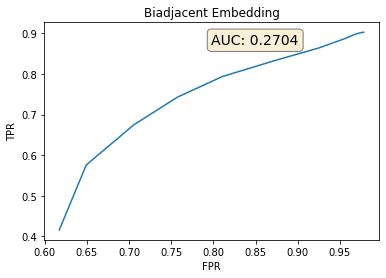

In [75]:
max_ind = np.argmax(pur)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-pur[max_ind:], eff[max_ind:])
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-pur[max_ind:], eff[max_ind:])), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("Biadjacent Embedding")

### F1 Results

In [46]:
def evaluate_embedding_f1(test_loader, model, r_min, r_max, r_step):
    
    model.eval()
    
    total_true_positive, total_positive, total_true = np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float)

    for batch in test_loader:

        data = batch.to(device)
        spatial = model(data.x)

        for i, r in enumerate(np.arange(r_min, r_max, r_step)):    
    #         e = radius_graph(emb_feats, r=r, batch=batch.batch, loop=False, max_num_neighbors=5000)

            e_spatial = build_edges(spatial, r, 100, res)
            e_bidir = torch.cat([batch.true_edges.to(device), 
                               torch.stack([batch.true_edges[1], batch.true_edges[0]], axis=1).T.to(device)], axis=-1) 
            array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
            l1 = e_spatial.cpu().numpy()
            l2 = e_bidir.cpu().numpy()
            e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
            e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
            e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

            e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
            y = e_final.data > 0

            true = 2*len(batch.true_edges[0])
            true_positive = y.sum()
            positive = len(e_spatial[0])

#             print("True:", true, "Positive:", positive, "True Positive:", true_positive)
            
            total_positive[i] += positive
            total_true[i] += true
            total_true_positive[i] += true_positive

    pur, eff = total_true_positive / total_positive, total_true_positive / total_true
    f1 = 2*pur*eff/(pur+eff)
    return pur, eff, f1

In [47]:
%%time

r_min, r_max, r_step = 0.8, 1.5, 0.1
pur, eff, f1 = evaluate_embedding_f1(test_loader, model, r_min, r_max, r_step)

CPU times: user 4min 40s, sys: 52.8 s, total: 5min 32s
Wall time: 4min 57s


In [48]:
pur, eff

(array([0.26986544, 0.21521619, 0.14788831, 0.08549938, 0.05027146,
        0.03457989, 0.02805509]),
 array([0.73000633, 0.7817497 , 0.82175829, 0.85402927, 0.87859028,
        0.89304132, 0.89871454]))

Text(0.5, 1.0, 'Biadjacent Embedding')

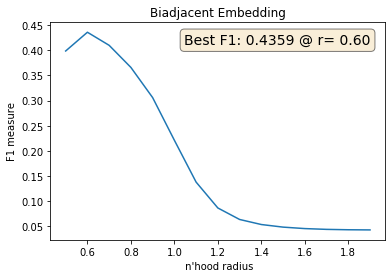

In [74]:
fig, ax = plt.subplots()
ax.plot(np.arange(r_min, r_max, r_step), f1)
ax.text(0.4, 0.95, "Best F1: {:.4f} @ r= {:.2f}".format(max(f1), r_min+r_step*np.argmax(f1)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel(" n'hood radius"), ax.set_ylabel("F1 measure")
ax.set_title("Biadjacent Embedding")

### V-measure Results

In [18]:
%%time

homogeneity, completeness = evaluate_embedding_vmeasure(test_loader, model, 0.01, 3., 0.1)

CPU times: user 27.4 s, sys: 20 ms, total: 27.4 s
Wall time: 27.5 s


Text(0.5, 1.0, 'Biadjacent Embedding')

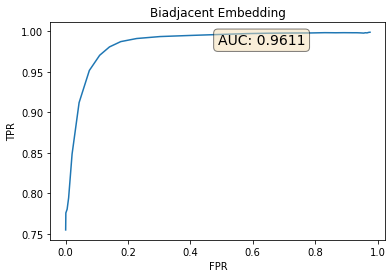

In [20]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-homogeneity, completeness)
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-homogeneity, completeness)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("Biadjacent Embedding")

In [57]:
%%time
model.eval()
correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0

for batch in test_loader[:10]:
    data = batch.to(device)
    spatial = model(data.x)

    e_spatial = build_edges(spatial, 1, 100, res)
    
#     embedded = spatial.cpu().detach().numpy()
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(embedded)
#     plt.figure(figsize=(16,10))
#     plt.scatter(pca_result[:,0], pca_result[:,1])

TypeError: 'DataLoader' object is not subscriptable

### Visualisation

In [70]:
model.eval()
data = test_dataset[2]
data = data.to(device)
spatial = model(data.x)

e_spatial = build_edges(spatial, 1., 100, res)

In [71]:
y_cluster = (data.pid[e_spatial[0]] == data.pid[e_spatial[1]])

In [72]:
e_bidir = torch.cat([data.true_edges.to(device), 
                               torch.stack([data.true_edges[1], data.true_edges[0]], axis=1).T.to(device)], axis=-1) 
        
df0 = pd.DataFrame(e_spatial.cpu().numpy().T)
df1 = pd.DataFrame(e_bidir.cpu().numpy().T)
df_merged = df0.merge(df1, how='left', indicator='Exist')

y = np.where(df_merged.Exist == 'both', 1, 0)

In [73]:
print("Adjacent Pur:", y.sum()/len(df0), "Adjacent Eff:", y.sum()/len(df1), "Global Pur:", y_cluster.sum().item()/len(df0))

Adjacent Pur: 0.21192973793797337 Adjacent Eff: 0.7128364616300568 Global Pur: 0.32751115603543846


In [119]:
e_spatial.shape

torch.Size([2, 274166])

In [82]:
(data.pid[e_spatial[0]] == data.pid[e_spatial[1]] ).sum()

tensor(172510, device='cuda:0')

In [155]:
embedded = spatial.cpu().detach().numpy()
pca = PCA(n_components=3)
px = pca.fit_transform(embedded)

In [ ]:
initial = np.random.choice(e[0])
source_idx = e_spatial[0] == initial
sources = e_spatial[0, source_idx]

target

(9.581162452697754, 12.410853385925293)

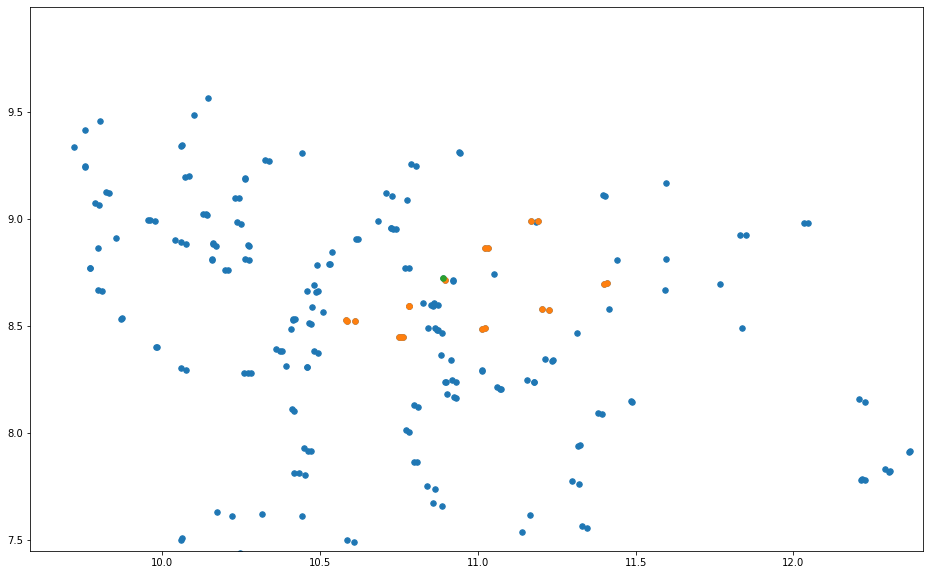

In [157]:
plt.figure(figsize=(16,10))
plt.scatter(px[:,0], px[:,1], s=30)
source = np.random.choice(e_spatial[0].cpu())
targets = e_spatial[1, e_spatial[0,:] == source].cpu()
plt.scatter(px[targets,0], px[targets,1], s=30)
plt.scatter(px[source,0], px[source,1], s=30)
plt.ylim(min(px[targets,1])-1, max(px[targets,1])+1)
plt.xlim(min(px[targets,0])-1, max(px[targets,0])+1)

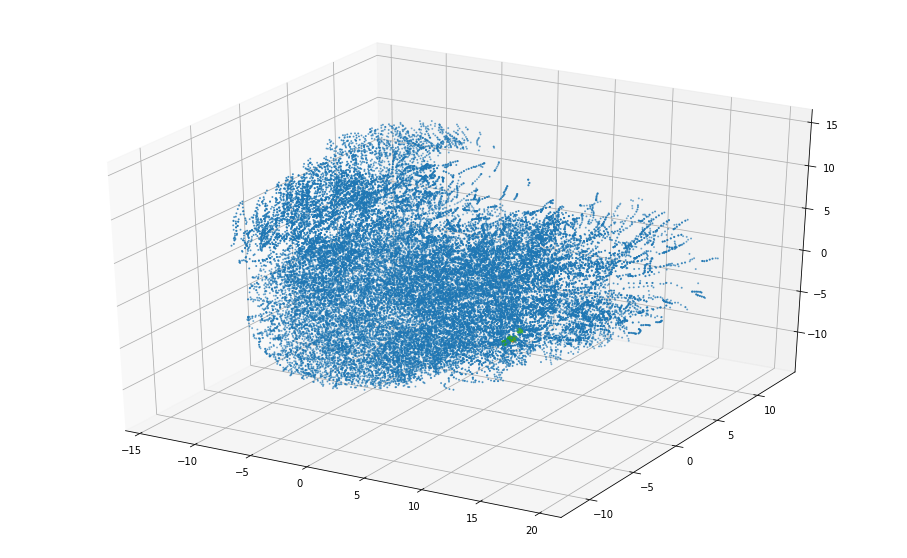

In [133]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px[:,0], px[:,2], px[:,1], s=1)

ax.scatter(px[source,0], px[source,1], px[source,2], s=30)
targets = e_spatial[1, e_spatial[0,:] == source].cpu()
ax.scatter(px[targets,0], px[targets,1], px[targets,2], s=30)

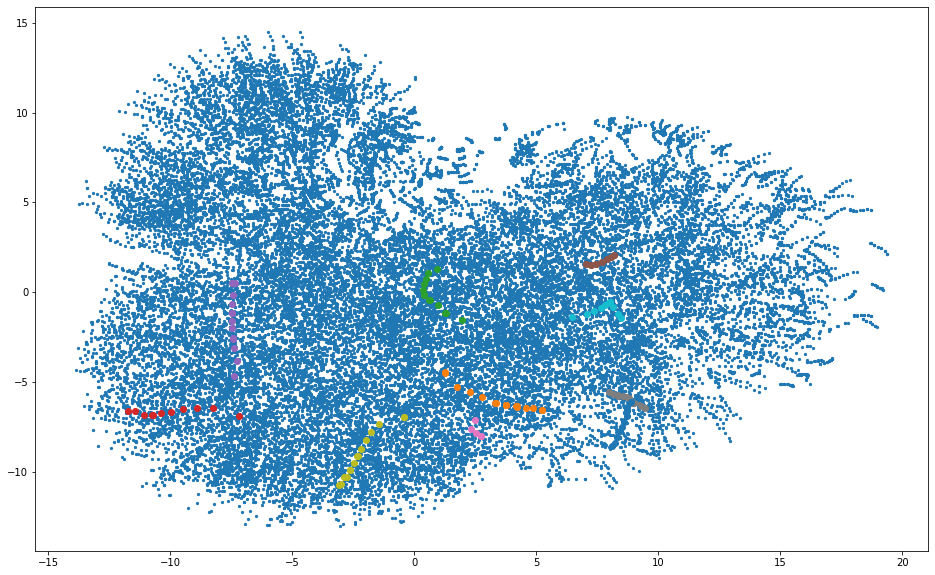

In [134]:
plt.figure(figsize=(16,10))
plt.scatter(px[:,0], px[:,1], s=5)
for P in data.pid.unique()[10:20]:
    Pmask = (data.pid == P).cpu()
    plt.scatter(px[Pmask,0], px[Pmask,1])

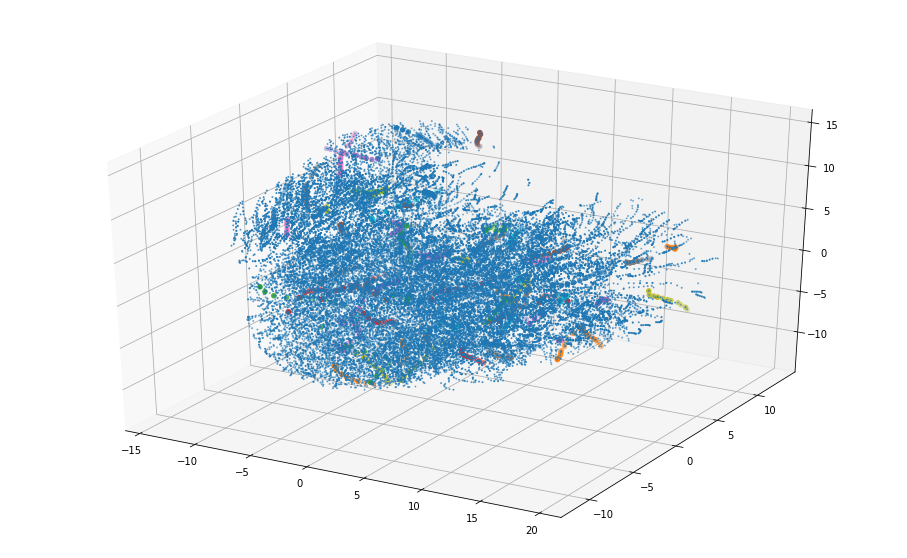

In [142]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px[:,0], px[:,2], px[:,1], s=1)
for P in data.pid.unique()[::50]:
    Pmask = (data.pid == P).cpu()
    ax.scatter(px[Pmask,0], px[Pmask,2], px[Pmask,1])

## 2a. Dynamic HNM

### Training

In [4]:
def train_connected_emb(model, train_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(data.x)
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        
        # Get clustered edge list
        tic = tt()
        if i==0 or knn_av[-1] > 100:
            e_spatial = build_edges(spatial, m_configs['r_train'], 500, res) 
        else:
            e_spatial = build_edges(spatial, m_configs['r_train'], 100, res) 
        knn_av.append(e_spatial.shape[1] / len(spatial))
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1  
        t1.append(tt() - tic)
        
        tic = tt()
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
#         print(y_cluster.sum(), len(y_cluster))
    
        eff_vec.append(y_cluster.sum() / e_bidir.shape[1])
        pur_vec.append(y_cluster.sum() / e_spatial.shape[1])
    
        e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,m_configs['weight']).view(-1, 2).transpose(0,1)], axis=-1) 
        y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*m_configs['weight'])])
        t2.append(tt() - tic)
        
        
#         print(y_cluster.sum(), len(y_cluster))
        tic = tt()
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        loss_vec.append(loss.item())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr.append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()
        
        print(i, knn_av[-1])
            
    return total_loss

def evaluate_connected_emb(model, test_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        spatial = model(data.x)
        e_spatial = build_edges(spatial, m_configs['r_val'], 1000, res)  
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
    
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss:", loss.item())
        total_loss += loss.item()
        
        #Cluster performance
        cluster_true = 2*len(batch.layerless_true_edges[0])
        
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])
        
        cluster_total_true_positive += cluster_true_positive
        cluster_total_positive += max(cluster_positive, 1)
        cluster_total_true += cluster_true
#         total_av_adjacent_nhood_size += len(e_adjacent[0]) / len(spatial)
        
#         print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive, "Av nhood size:", len(e_spatial[0])/len(spatial))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss


In [9]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'weight': 1}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnections", config=m_configs)
wandb.watch(model, log='all')
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-3, amsgrad=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.3)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [10]:
t1, t2, = [], []
knn_av = []
loss_vec = []
eff_vec = []
pur_vec = []
lr = []
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_emb(model, train_loader, other_configs)
    print('Training loss: {:.4f}'.format(train_loss), "in time", tt() - tic)

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))
    break

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


0 499.0


RuntimeError: CUDA out of memory. Tried to allocate 790.00 MiB (GPU 0; 15.78 GiB total capacity; 9.82 GiB already allocated; 299.75 MiB free; 12.87 GiB reserved in total by PyTorch) (malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:289)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x46 (0x2aab31aaa536 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1cf1e (0x2aab3186af1e in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1df9e (0x2aab3186bf9e in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x135 (0x2aaafc936fd5 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0xf9310b (0x2aaafaf2f10b in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xfdc9f7 (0x2aaafaf789f7 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0x1075389 (0x2aaaec275389 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #7: <unknown function> + 0x10756c7 (0x2aaaec2756c7 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xe3c42e (0x2aaaec03c42e in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::TensorIterator::fast_set_up() + 0x5cf (0x2aaaec03d2af in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::TensorIterator::build() + 0x4c (0x2aaaec03db6c in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: at::TensorIterator::binary_op(at::Tensor&, at::Tensor const&, at::Tensor const&, bool) + 0x146 (0x2aaaec03e216 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::native::mul(at::Tensor const&, at::Tensor const&) + 0x3a (0x2aaaebd5deba in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #13: <unknown function> + 0xf8f998 (0x2aaafaf2b998 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #14: <unknown function> + 0x10c3ec0 (0x2aaaec2c3ec0 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x2d2e779 (0x2aaaedf2e779 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #16: <unknown function> + 0x10c3ec0 (0x2aaaec2c3ec0 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #17: at::Tensor::mul(at::Tensor const&) const + 0xf0 (0x2aaaea858d10 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #18: torch::autograd::generated::PowBackward0::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x1a6 (0x2aaaedac3a06 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2d89c05 (0x2aaaedf89c05 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x2aaaedf86f03 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x2aaaedf87ce2 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::Engine::thread_init(int) + 0x39 (0x2aaaedf80359 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #23: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x2aaaea616828 in /global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #24: <unknown function> + 0xc819d (0x2aaaae2ab19d in /global/u2/d/danieltm/.conda/envs/exatrkx-test/bin/../lib/libstdc++.so.6)
frame #25: <unknown function> + 0x7569 (0x2aaaaacda569 in /lib64/libpthread.so.0)
frame #26: clone + 0x3f (0x2aaaaafe9a2f in /lib64/libc.so.6)


## 3. Balanced Random Pairs with HNM

### Training

In [4]:
def train_connected_emb(model, train_loader, optimizer, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(data.x)
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        
        # Get clustered edge list
        tic = tt()
        e_spatial = build_edges(spatial, m_configs['r_train'], 200, res) 
        knn_av.append(e_spatial.shape[1] / len(spatial))
               
        if i==0 or knn_av[-1] > 100:
            n_random = int(m_configs['randomisation']*e_spatial.shape[1])
            e_random = torch.randint(e_spatial.min(), e_spatial.max(), (2, n_random)).to(device)
            e_spatial = torch.cat([e_spatial, e_random], axis=-1)
        
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1  
        t1.append(tt() - tic)
        
        tic = tt()
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
#         print(y_cluster.sum(), len(y_cluster))
    
        eff_vec.append(y_cluster.sum() / e_bidir.shape[1])
        pur_vec.append(y_cluster.sum() / e_spatial.shape[1])
    
        e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,m_configs['weight']).view(-1, 2).transpose(0,1)], axis=-1) 
        y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*m_configs['weight'])])
        t2.append(tt() - tic)
        
        
#         print(y_cluster.sum(), len(y_cluster))
        tic = tt()
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        loss_vec.append(loss.item())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr.append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()
        
        print("i:", i, "LR:", optimizer.param_groups[0]['lr'], "KNN:", knn_av[-1], "LOSS:", loss.item())
            
    return total_loss

def evaluate_connected_emb(model, test_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        spatial = model(data.x)
        e_spatial = build_edges(spatial, m_configs['r_val'], 500, res)  
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
    
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss:", loss.item())
        total_loss += loss.item()
        
        #Cluster performance
        cluster_true = 2*len(batch.layerless_true_edges[0])
        
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])
        
        cluster_total_true_positive += cluster_true_positive
        cluster_total_positive += max(cluster_positive, 1)
        cluster_total_true += cluster_true
#         total_av_adjacent_nhood_size += len(e_adjacent[0]) / len(spatial)
        
#         print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive, "Av nhood size:", len(e_spatial[0])/len(spatial))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss


In [5]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'weight': 16, 'randomisation': 1}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnections", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=0)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001, lr_decay=0, weight_decay=1e-3, initial_accumulator_value=0, eps=1e-10)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=True)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
t1, t2, = [], []
knn_av = []
loss_vec = []
eff_vec = []
pur_vec = []
lr = []
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss), "in time", tt() - tic)

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))
    break

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


i: 0 LR: 0.01 KNN: 199.0 LOSS: 0.9230878949165344
i: 1 LR: 0.01 KNN: 193.05888086893958 LOSS: 0.8017261624336243
i: 2 LR: 0.01 KNN: 187.01012026199936 LOSS: 0.969643235206604
i: 3 LR: 0.01 KNN: 191.79740813648294 LOSS: 0.7925176620483398
i: 4 LR: 0.01 KNN: 198.83048740356136 LOSS: 0.6872989535331726
i: 5 LR: 0.01 KNN: 198.94095959221042 LOSS: 0.5927004814147949
i: 6 LR: 0.01 KNN: 199.0 LOSS: 0.5334367752075195
i: 7 LR: 0.01 KNN: 198.75533833581974 LOSS: 0.5231006145477295
i: 8 LR: 0.01 KNN: 199.0 LOSS: 0.5416933298110962
i: 9 LR: 0.01 KNN: 198.93235544374977 LOSS: 0.556516706943512
i: 10 LR: 0.01 KNN: 199.0 LOSS: 0.5946527719497681
i: 11 LR: 0.01 KNN: 198.99021243242157 LOSS: 0.6258009076118469
i: 12 LR: 0.01 KNN: 198.96458313617867 LOSS: 0.5508801341056824
i: 13 LR: 0.01 KNN: 198.93679165491966 LOSS: 0.5250973701477051
i: 14 LR: 0.01 KNN: 198.95582837301586 LOSS: 0.5084723234176636
i: 15 LR: 0.01 KNN: 198.86190614557606 LOSS: 0.5056572556495667
i: 16 LR: 0.01 KNN: 198.64308278069495 L

i: 129 LR: 0.01 KNN: 129.8846475955393 LOSS: 0.3706452250480652
i: 130 LR: 0.01 KNN: 101.75686668692583 LOSS: 0.4253329038619995
i: 131 LR: 0.01 KNN: 107.73373166757197 LOSS: 0.4215644896030426
i: 132 LR: 0.01 KNN: 110.29343365253078 LOSS: 0.37079259753227234
i: 133 LR: 0.01 KNN: 108.28521526691382 LOSS: 0.3769482672214508
i: 134 LR: 0.01 KNN: 93.00001934872202 LOSS: 0.7420082688331604
i: 135 LR: 0.01 KNN: 116.09855656445781 LOSS: 0.4006950259208679
i: 136 LR: 0.01 KNN: 129.461237215315 LOSS: 0.37886351346969604
i: 137 LR: 0.01 KNN: 104.87369654364382 LOSS: 0.38540488481521606
i: 138 LR: 0.01 KNN: 114.00369032974882 LOSS: 0.37657347321510315
i: 139 LR: 0.01 KNN: 91.93198577427717 LOSS: 0.7546497583389282
i: 140 LR: 0.01 KNN: 121.0870045229531 LOSS: 0.43959975242614746
i: 141 LR: 0.01 KNN: 94.08711568711568 LOSS: 0.7122802138328552
i: 142 LR: 0.01 KNN: 117.25729769676069 LOSS: 0.39524540305137634
i: 143 LR: 0.01 KNN: 114.33572639345897 LOSS: 0.3795549273490906
i: 144 LR: 0.01 KNN: 114.2

i: 257 LR: 0.01 KNN: 68.15438346092297 LOSS: 0.6526342034339905
i: 258 LR: 0.01 KNN: 62.20979671693071 LOSS: 0.6371420621871948
i: 259 LR: 0.01 KNN: 67.8034135865265 LOSS: 0.6236582398414612
i: 260 LR: 0.01 KNN: 57.127317432997295 LOSS: 0.6648359894752502
i: 261 LR: 0.01 KNN: 77.56764029935768 LOSS: 0.6055432558059692
i: 262 LR: 0.01 KNN: 59.55879064460924 LOSS: 0.6722655296325684
i: 263 LR: 0.01 KNN: 55.54565621869185 LOSS: 0.6820845603942871
i: 264 LR: 0.01 KNN: 60.408728073467955 LOSS: 0.6232085824012756
i: 265 LR: 0.01 KNN: 79.24022604972322 LOSS: 0.5744154453277588
i: 266 LR: 0.01 KNN: 67.25353626470644 LOSS: 0.6654874682426453
i: 267 LR: 0.01 KNN: 72.81787518037518 LOSS: 0.6352100372314453
i: 268 LR: 0.01 KNN: 56.04882916753696 LOSS: 0.687759280204773
i: 269 LR: 0.01 KNN: 72.09615862635997 LOSS: 0.6158811450004578
i: 270 LR: 0.01 KNN: 58.433877418657445 LOSS: 0.6764770746231079
i: 271 LR: 0.01 KNN: 70.46013012558632 LOSS: 0.6318343877792358
i: 272 LR: 0.01 KNN: 67.91984020764895 

i: 386 LR: 0.01 KNN: 51.410211668310446 LOSS: 0.6420696377754211
i: 387 LR: 0.01 KNN: 75.35441314304914 LOSS: 0.5728193521499634
i: 388 LR: 0.01 KNN: 51.125357359438624 LOSS: 0.6749549508094788
i: 389 LR: 0.01 KNN: 58.524272254848114 LOSS: 0.630643367767334
i: 390 LR: 0.01 KNN: 55.54830604118311 LOSS: 0.6302991509437561
i: 391 LR: 0.01 KNN: 58.386250548109736 LOSS: 0.6644823551177979
i: 392 LR: 0.01 KNN: 61.3820342261611 LOSS: 0.6179934144020081
i: 393 LR: 0.01 KNN: 52.74976905571953 LOSS: 0.6234695911407471
i: 394 LR: 0.01 KNN: 66.2133195719485 LOSS: 0.597571074962616
i: 395 LR: 0.01 KNN: 45.43719639139486 LOSS: 0.6808631420135498
i: 396 LR: 0.01 KNN: 45.96845567769687 LOSS: 0.6257772445678711
i: 397 LR: 0.01 KNN: 55.2128771026519 LOSS: 0.6075171232223511
i: 398 LR: 0.01 KNN: 66.07955658270986 LOSS: 0.592038631439209
i: 399 LR: 0.01 KNN: 55.898141324817814 LOSS: 0.6507474184036255
i: 400 LR: 0.01 KNN: 48.76510228063023 LOSS: 0.6716127991676331
i: 401 LR: 0.01 KNN: 55.96797308817769 LO

i: 514 LR: 0.001 KNN: 45.04913920875613 LOSS: 0.5962031483650208
i: 515 LR: 0.001 KNN: 45.69909913859237 LOSS: 0.5860947966575623
i: 516 LR: 0.001 KNN: 54.25082218811664 LOSS: 0.5644872784614563
i: 517 LR: 0.001 KNN: 38.53909443591012 LOSS: 0.6160820722579956
i: 518 LR: 0.001 KNN: 41.251554360611664 LOSS: 0.6003950238227844
i: 519 LR: 0.001 KNN: 45.23759398496241 LOSS: 0.56600421667099
i: 520 LR: 0.001 KNN: 55.311672505992995 LOSS: 0.5497846007347107
i: 521 LR: 0.001 KNN: 48.533034667559875 LOSS: 0.5797250270843506
i: 522 LR: 0.001 KNN: 43.793552022917794 LOSS: 0.5850788950920105
i: 523 LR: 0.001 KNN: 38.05629693662542 LOSS: 0.5897732973098755
i: 524 LR: 0.001 KNN: 41.59505485108358 LOSS: 0.5757351517677307
i: 525 LR: 0.001 KNN: 53.700627934604285 LOSS: 0.5558351874351501
i: 526 LR: 0.001 KNN: 53.293981349590716 LOSS: 0.564639687538147
i: 527 LR: 0.001 KNN: 47.478508717180546 LOSS: 0.5622045397758484
i: 528 LR: 0.001 KNN: 43.35783512769434 LOSS: 0.5857345461845398
i: 529 LR: 0.001 KNN:

i: 640 LR: 0.001 KNN: 49.19435092845497 LOSS: 0.5184314250946045
i: 641 LR: 0.001 KNN: 43.1529539859875 LOSS: 0.5352054834365845
i: 642 LR: 0.001 KNN: 39.45360900958624 LOSS: 0.5465050935745239
i: 643 LR: 0.001 KNN: 39.06226443539877 LOSS: 0.5555481314659119
i: 644 LR: 0.001 KNN: 36.671613022469835 LOSS: 0.5670683979988098
i: 645 LR: 0.001 KNN: 36.58793819751813 LOSS: 0.5622521042823792
i: 646 LR: 0.001 KNN: 51.57700392654583 LOSS: 0.5046055912971497
i: 647 LR: 0.001 KNN: 57.45364905460329 LOSS: 0.4978717267513275
i: 648 LR: 0.001 KNN: 43.103915137134486 LOSS: 0.5448164939880371
i: 649 LR: 0.001 KNN: 40.06903871668074 LOSS: 0.5455643534660339
i: 650 LR: 0.001 KNN: 46.298213310131324 LOSS: 0.5403289198875427
i: 651 LR: 0.001 KNN: 50.04622658665212 LOSS: 0.5393167734146118
i: 652 LR: 0.001 KNN: 44.66734152612718 LOSS: 0.5608039498329163
i: 653 LR: 0.001 KNN: 42.355745590593266 LOSS: 0.5555248260498047
i: 654 LR: 0.001 KNN: 42.33583169535823 LOSS: 0.5679950714111328
i: 655 LR: 0.001 KNN: 

i: 766 LR: 0.001 KNN: 47.76300636427922 LOSS: 0.5274404883384705
i: 767 LR: 0.001 KNN: 56.0527758501041 LOSS: 0.49841561913490295
i: 768 LR: 0.001 KNN: 39.49829798376538 LOSS: 0.5468194484710693
i: 769 LR: 0.001 KNN: 44.81904702662354 LOSS: 0.5332406759262085
i: 770 LR: 0.001 KNN: 46.7357087145928 LOSS: 0.5431597232818604
i: 771 LR: 0.001 KNN: 37.57490099362091 LOSS: 0.5547166466712952
i: 772 LR: 0.001 KNN: 53.743910993654055 LOSS: 0.5157173871994019
i: 773 LR: 0.001 KNN: 49.82254606306762 LOSS: 0.5382757782936096
i: 774 LR: 0.001 KNN: 31.790898854804603 LOSS: 0.5871649980545044
i: 775 LR: 0.001 KNN: 33.43313631824684 LOSS: 0.5771698951721191
i: 776 LR: 0.001 KNN: 45.82416342647622 LOSS: 0.5339436531066895
i: 777 LR: 0.001 KNN: 46.97133309175826 LOSS: 0.5243149399757385
i: 778 LR: 0.001 KNN: 44.64480780755073 LOSS: 0.5126960873603821
i: 779 LR: 0.001 KNN: 35.89802648798618 LOSS: 0.5750702619552612
i: 780 LR: 0.001 KNN: 50.05918991633804 LOSS: 0.5264028906822205
i: 781 LR: 0.001 KNN: 50

i: 892 LR: 0.001 KNN: 41.891187990894736 LOSS: 0.5416979193687439
i: 893 LR: 0.001 KNN: 35.87926372218796 LOSS: 0.5762936472892761
i: 894 LR: 0.001 KNN: 41.20369086813377 LOSS: 0.5330415964126587
i: 895 LR: 0.001 KNN: 33.58046821985976 LOSS: 0.5514301657676697
i: 896 LR: 0.001 KNN: 38.17348501971421 LOSS: 0.5437177419662476
i: 897 LR: 0.001 KNN: 41.37811674977999 LOSS: 0.5306006073951721
i: 898 LR: 0.001 KNN: 47.3753681963714 LOSS: 0.5090651512145996
i: 899 LR: 0.001 KNN: 43.73794852401397 LOSS: 0.5158429145812988
i: 900 LR: 0.001 KNN: 43.08935945874703 LOSS: 0.5302355289459229
i: 901 LR: 0.001 KNN: 37.516110797060485 LOSS: 0.5436403155326843
i: 902 LR: 0.001 KNN: 48.00139688532327 LOSS: 0.5264938473701477
i: 903 LR: 0.001 KNN: 38.039031148480795 LOSS: 0.5540446043014526
i: 904 LR: 0.001 KNN: 38.44466562396322 LOSS: 0.5415360331535339
i: 905 LR: 0.001 KNN: 38.0354465919631 LOSS: 0.5379195213317871
i: 906 LR: 0.001 KNN: 43.49660104175863 LOSS: 0.5270868539810181
i: 907 LR: 0.001 KNN: 39

([<matplotlib.lines.Line2D at 0x2aab808578d0>],
 None,
 None,
 Text(0.5, 1.0, 'Learning Rate'))

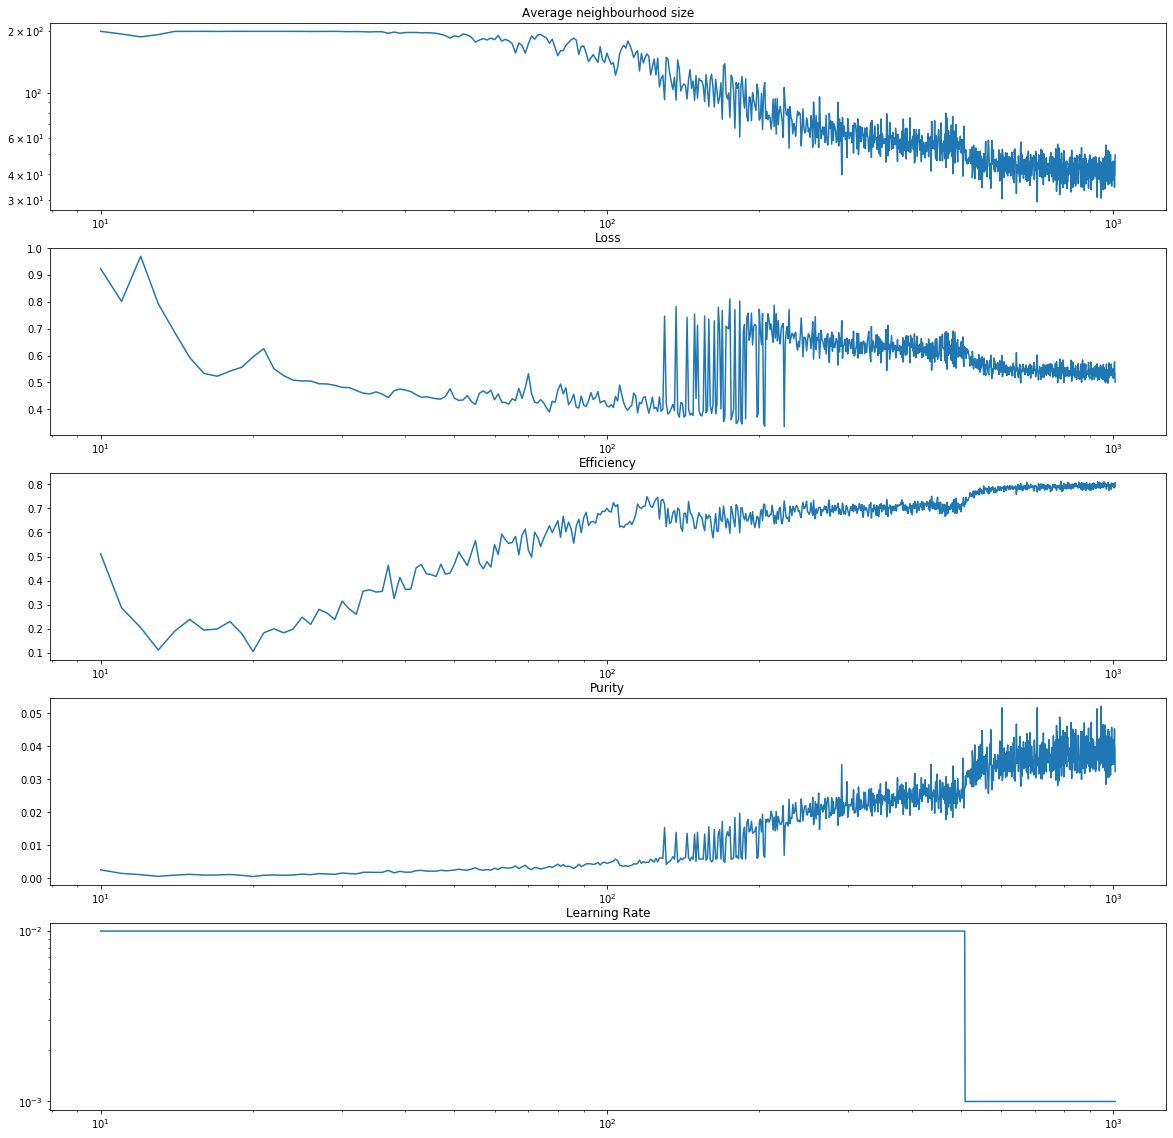

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(20, 20))
axs[0].plot(range(10,1010), knn_av[:]), axs[0].set_xscale('log'), axs[0].set_yscale('log'), axs[0].set_title('Average neighbourhood size')
axs[1].plot(range(10,1010), loss_vec[:]), axs[1].set_xscale('log'), axs[1].set_title('Loss')
axs[2].plot(range(10,1010), eff_vec[:]), axs[2].set_xscale('log'), axs[2].set_title('Efficiency')
axs[3].plot(range(10,1010), pur_vec[:]), axs[3].set_xscale('log'), axs[3].set_title('Purity')
axs[4].plot(range(10,1010), lr[:]), axs[4].set_xscale('log'), axs[4].set_yscale('log'), axs[4].set_title('Learning Rate')

## Balanced Margin Training

In [123]:
def train_connected_emb(model, train_loader, optimizer, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(data.x)
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 

        
        # Get clustered edge list
        e_spatial = build_edges(spatial, m_configs['r_train'], 10, res)       
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1  
            
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        
        fakes = (e_1 - e_2)>0
        fakes_lil = fakes.tolil()
        trues_lil = e_2.tolil()
        
        randoms = np.array([[[i, np.random.choice(x[0])], [i, np.random.choice(x[1])]] for i, x in enumerate(zip(fakes_lil.rows, trues_lil.rows)) if (x[0] and x[1])])
        y_cluster = np.tile([0,1],randoms.shape[0])
        e_spatial = torch.from_numpy(np.concatenate(randoms).T).long().to(device)
        
#         if m_configs['ratio'] != 0:
#             num_true = e_bidir.shape[1]
#             set_indices = np.random.choice(np.where(~y_cluster)[0], int(num_true*m_configs['ratio']), replace=True)
        
#         else:
#             set_indices = np.arange(0, e_spatial.shape[1])
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
        
#         print(hinge, d)

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(i, loss.item(), optimizer.param_groups[0]['lr'])
    
    return total_loss

def evaluate_connected_emb(model, test_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    total_loss = 0
    
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        spatial = model(data.x)
        e_spatial = build_edges(spatial, m_configs['r_val'], 100, res)  
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 

        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
    
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        total_loss += loss.item()
        
        #Cluster performance
        cluster_true = e_bidir.shape[1]
        
        cluster_true_positive = y_cluster.sum()
        cluster_positive = e_spatial.shape[1]
        
        cluster_total_true_positive += cluster_true_positive
        cluster_total_positive += max(cluster_positive, 1)
        cluster_total_true += cluster_true
        
    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss


In [124]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'ratio': 1}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnections", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-3, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.3)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss), 'in time', tt() - tic)

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


0 0.5000274181365967 0.005
1 0.5077991485595703 0.005
2 2.8065106868743896 0.005
3 1.463269829750061 0.005
4 0.80517578125 0.005
5 0.674381673336029 0.005
6 0.5111755728721619 0.005
7 0.5045705437660217 0.005
8 0.5016823410987854 0.005
9 0.5010886192321777 0.005
10 0.5008518099784851 0.005
11 0.5006449818611145 0.005
12 0.5004178881645203 0.005
13 0.5002102851867676 0.005
14 0.5001201629638672 0.005
15 0.5000840425491333 0.005
16 0.4999379813671112 0.005
17 0.5000669956207275 0.005
18 0.5000581741333008 0.005
19 0.5000583529472351 0.005
20 0.5000532865524292 0.005
21 0.500044584274292 0.005
22 0.5000393390655518 0.005
23 0.5000332593917847 0.005
24 0.5000260472297668 0.005
25 0.5000219941139221 0.005
26 0.5000179409980774 0.005
27 0.5000154972076416 0.005
28 0.5000129342079163 0.005
29 0.49992674589157104 0.005
30 0.5000096559524536 0.005
31 0.5000098347663879 0.005
32 0.5000093579292297 0.005
33 0.5000085830688477 0.005
34 0.49987706542015076 0.005
35 0.5000105500221252 0.005
36 0.500

288 0.5000308156013489 0.005
289 0.5000268220901489 0.005
290 0.5000233054161072 0.005
291 0.5000206232070923 0.005
292 0.500017523765564 0.005
293 0.49985840916633606 0.005
294 0.4998875558376312 0.005
295 0.5000156760215759 0.005
296 0.4998627007007599 0.005
297 0.5000187158584595 0.005
298 0.5000205636024475 0.005
299 0.5000237226486206 0.0015
300 0.5000237226486206 0.0015
301 0.5000241994857788 0.0015
302 0.49989375472068787 0.0015
303 0.5000250935554504 0.0015
304 0.5000259280204773 0.0015
305 0.5000260472297668 0.0015
306 0.50002521276474 0.0015
307 0.500024676322937 0.0015
308 0.5000247955322266 0.0015
309 0.50002521276474 0.0015
310 0.49989721179008484 0.0015
311 0.5000253915786743 0.0015
312 0.4998638331890106 0.0015
313 0.5000253319740295 0.0015
314 0.5000258684158325 0.0015
315 0.5000264048576355 0.0015
316 0.5000259280204773 0.0015
317 0.49989053606987 0.0015
318 0.500026524066925 0.0015
319 0.499878466129303 0.0015
320 0.5000278949737549 0.0015
321 0.5000284314155579 0.001

563 0.4998646378517151 0.0015
564 0.5000181198120117 0.0015
565 0.5000208616256714 0.0015
566 0.5000244379043579 0.0015
567 0.5000242590904236 0.0015
568 0.5000255107879639 0.0015
569 0.5000274777412415 0.0015
570 0.5000283122062683 0.0015
571 0.5000287890434265 0.0015
572 0.4998626410961151 0.0015
573 0.5000298023223877 0.0015
574 0.5000298619270325 0.0015
575 0.5000312328338623 0.0015
576 0.5000318288803101 0.0015
577 0.5000307559967041 0.0015
578 0.5000303983688354 0.0015
579 0.5000293850898743 0.0015
580 0.49989691376686096 0.0015
581 0.5000300407409668 0.0015
582 0.5000278949737549 0.0015
583 0.5000282526016235 0.0015
584 0.500028669834137 0.0015
585 0.5000271201133728 0.0015
586 0.5000258684158325 0.0015
587 0.49989911913871765 0.0015
588 0.5000261068344116 0.0015
589 0.5000250935554504 0.0015
590 0.500025749206543 0.0015
591 0.5000239610671997 0.0015
592 0.500024139881134 0.0015
593 0.5000240206718445 0.0015
594 0.500022292137146 0.0015
595 0.5000206232070923 0.0015
596 0.500020

829 0.5000178217887878 0.00045
830 0.5000177621841431 0.00045
831 0.5000190734863281 0.00045
832 0.5000171661376953 0.00045
833 0.5000188946723938 0.00045
834 0.4998783767223358 0.00045
835 0.49986734986305237 0.00045
836 0.5000197887420654 0.00045
837 0.5000189542770386 0.00045
838 0.5000190734863281 0.00045
839 0.4998704195022583 0.00045
840 0.5000203847885132 0.00045
841 0.5000203251838684 0.00045
842 0.5000209808349609 0.00045
843 0.49982979893684387 0.00045
844 0.5000216960906982 0.00045
845 0.5000225901603699 0.00045
846 0.5000225901603699 0.00045
847 0.5000224709510803 0.00045
848 0.49988022446632385 0.00045
849 0.500024676322937 0.00045
850 0.5000254511833191 0.00045
851 0.49984127283096313 0.00045
852 0.5000247955322266 0.00045
853 0.4998885691165924 0.00045
854 0.5000265836715698 0.00045
855 0.5000255107879639 0.00045
856 0.5000259876251221 0.00045
857 0.5000272393226624 0.00045
858 0.500027596950531 0.00045


In [121]:
torch.cuda.max_memory_allocated() / 1024**3

3.7186007499694824

#### Explore Sparse Matched Selection

In [78]:
cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
total_loss = 0
for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    data = batch.to(device)
    spatial = model(data.x)
    e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 


    # Get clustered edge list
    e_spatial = build_edges(spatial, m_configs['r_train'], 100, res)       
    array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1  

    l1 = e_spatial.cpu().numpy()
    l2 = e_bidir.cpu().numpy()
    e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
    e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
    
    reals = e_1.multiply(e_2)
    fakes = (e_1 - e_2)>0
    
    e_final = (reals - fakes).tocoo()

    e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
    y_cluster = e_final.data > 0

    if m_configs['ratio'] != 0:
        num_true = e_bidir.shape[1]
        set_indices = np.random.choice(np.where(~y_cluster)[0], int(num_true*m_configs['ratio']), replace=True)

    else:
        set_indices = np.arange(0, e_spatial.shape[1])

    e_spatial = e_spatial[:, set_indices]
    y_cluster = y_cluster[set_indices]

    e_spatial = torch.cat([e_spatial, e_bidir], axis=-1) 
    y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1])])

#         print("y sum", y_cluster.sum(), "y len", len(y_cluster))

    hinge = torch.from_numpy(y_cluster).float().to(device)
    hinge[hinge == 0] = -1

    reference = spatial.index_select(0, e_spatial[1])
    neighbors = spatial.index_select(0, e_spatial[0])
    d = torch.sum((reference - neighbors)**2, dim=-1)

#         print(hinge, d)

    loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
    total_loss += loss.item()
    loss.backward()
    optimizer.step()

    break

In [79]:
fakes = (e_1 - e_2)>0
trues = e_2

In [80]:
%%time
fakes_lil = fakes.tolil()
trues_lil = trues.tolil()

CPU times: user 847 ms, sys: 51.1 ms, total: 898 ms
Wall time: 896 ms


In [104]:
%%time
randoms = np.array([[[i, np.random.choice(x[0])], [i, np.random.choice(x[1])]] for i, x in enumerate(zip(fakes_lil.rows, trues_lil.rows)) if (x[0] and x[1])])

CPU times: user 944 ms, sys: 7.2 ms, total: 951 ms
Wall time: 950 ms


(89732,)

array([[    1, 15862],
       [    1,  2460],
       [    2, 15565],
       ...,
       [46183, 46174],
       [46184, 45224],
       [46184, 46174]])

In [50]:
for x in zip(fakes_lil.rows, reals_lil.rows):
    print(x[0])
    break

[0, 66, 2563, 3077, 3483, 3887, 6197, 8064, 8866, 9027, 11681, 11934, 13513, 16260, 16486, 16732, 17802, 18689, 24253, 24428, 26089, 26686, 27062, 27262, 27390, 27480, 27767, 27932, 27965, 28020, 28233, 28309, 28506, 28513, 28519, 28574, 28695, 28715, 28889, 28904, 28964, 28970, 29188, 29333, 29395, 29406, 29540, 29561, 29595, 29618, 29668, 29873, 29878, 29927, 30144, 30152, 30184, 30227, 30245, 30272, 30448, 30492, 30574, 30594, 30625, 30665, 30725, 30785, 30797, 30923, 30926, 30988, 31050, 31053, 31155, 31234, 31342, 31407, 31408, 31475, 31543, 31595, 31613, 31680, 31891, 31912, 32081, 32209, 32257, 32399, 32445, 32497, 32830, 32946, 33054, 33107, 33625, 33633, 33753]


## Balanced Triplet Training

In [ ]:
def train_connected_emb(model, train_loader, optimizer, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = [0]*3
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(data.x)
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 

        
        # Get clustered edge list
        e_spatial = build_edges(spatial, m_configs['r_train'], 10, res)       
        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1  
            
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        if m_configs['ratio'] != 0:
            num_true = e_bidir.shape[1]
            set_indices = np.random.choice(np.where(~y_cluster)[0], int(num_true*m_configs['ratio']), replace=True)
        
        else:
            set_indices = np.arange(0, e_spatial.shape[1])
        
        e_spatial = e_spatial[:, set_indices]
        y_cluster = y_cluster[set_indices]
        
        e_spatial = torch.cat([e_spatial, e_bidir], axis=-1) 
        y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1])])
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        loss = torch.nn.functional.triplet_margin_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    return total_loss

def evaluate_connected_emb(model, test_loader, m_configs):
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = [0]*3
    total_loss = 0
    
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        spatial = model(data.x)
        e_spatial = build_edges(spatial, m_configs['r_val'], 1024, res)  
        e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 

        array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir.cpu().numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()
                
        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
        y_cluster = e_final.data > 0
        
        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
    
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        total_loss += loss.item()
        
        #Cluster performance
        cluster_true = 2*len(batch.true_edges[0])
        
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])
        
        cluster_total_true_positive += cluster_true_positive
        cluster_total_positive += max(cluster_positive, 1)
        cluster_total_true += cluster_true
        
    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss


In [ ]:
m_configs = {"in_channels": 3, "emb_hidden": 64, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'ratio': 1}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnections", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

In [ ]:
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss))

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_connected_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))